In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
from modules.settings import global_mmf_settings as gset
from wrapper_scripts import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from modules.settings import global_mmf_settings as gset
from cosmology import cosmo_fn
import multiprocessing as mp
from scipy.optimize import curve_fit
import bces.bces as bces
import time
from astropy.io import fits
from fitstat import fit_Y_M_scaling_law as fit 

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset="planck_pr1"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

('planck_pr1_hfi_inpainted_data', 'hfi_inpainted_data')

# Initialize MMF analysis

In [3]:
outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling() ; xsz_cat=pmmf.xsz_cat

ysz_cat=ymsr.ppd.get_cosmo_catalogue_ysz()
xsz_cat["BIAS"]=np.copy(ysz_cat["BIAS"])
xsz_cat["T500"]=np.copy(xsz_cat["TX"])
xsz_cat["M500"]=np.copy(ysz_cat["M_Yx_500"]/1e14)
xsz_cat["M500_err"]=(ysz_cat['ERRM_M_Yx_500'] + ysz_cat['ERRP_M_Yx_500'])*0.5/1e14
xsz_cat["YSZ_500"]=np.copy(ysz_cat['Y_500'])
xsz_cat["YSZ_500_err"]=np.copy(ysz_cat["ERR_Y_500"])

fxsz_cat={}

def wrap_eval_Y500_xray_prior(idx):
    result=pmmf.eval_Y500_xray_prior(idx)
    return result

def parallel_eval_Y500_xray_prior(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_xray_prior_iterative(idx):
    result=pmmf.eval_Y500_xray_prior_iterative(idx)
    return result

def parallel_eval_Y500_xray_prior_iterative(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior_iterative,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_blind(idx):
    result=pmmf.eval_Y500_blind(idx)
    return result

def parallel_eval_Y500_blind(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_blind,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

In [5]:
outpath

'/results/planck_pr1/planck_cosmo_cat_hfi_inpainted_data/'

# Extract data tangent planes

In [5]:
# ymsr.ppd.extract_tangent_planes()

In [6]:
# def parallel_psfill(numprocs):
#     pool=mp.Pool(processes=numprocs)
#     pool.map(ymsr.ppd.gen_ps_inpainted_data,pmmf.idx_list)
#     pool.close()
#     pool.join()
    
# start=time.time()
# parallel_psfill(numprocs)
# print time.time()-start

# Testing iterative scheme

0.0002861980901349138 5.553040141503219e-05


<IPython.core.display.Javascript object>


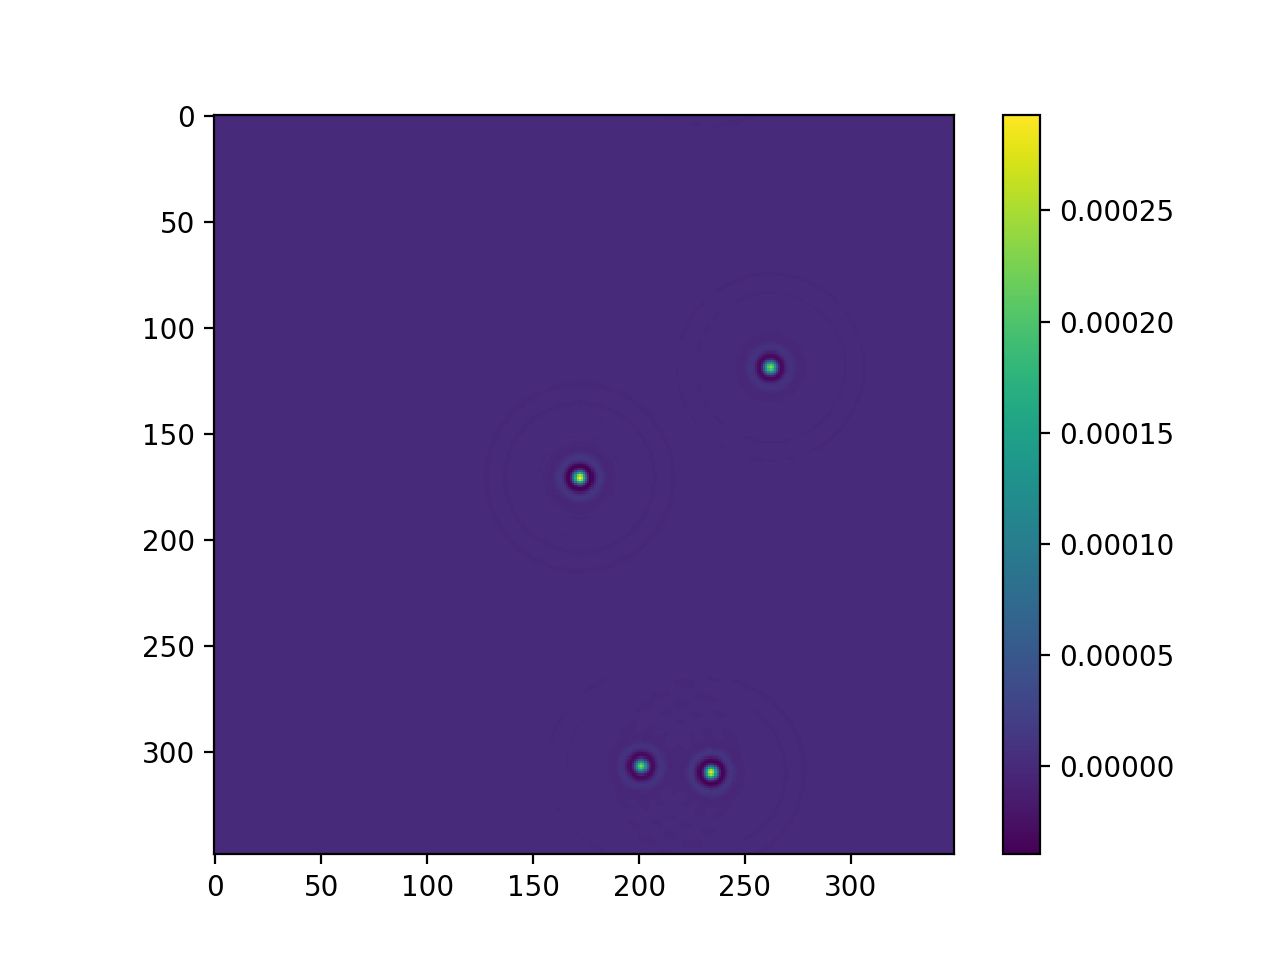

0.000277136460005235 6.252526863086395e-05


<IPython.core.display.Javascript object>


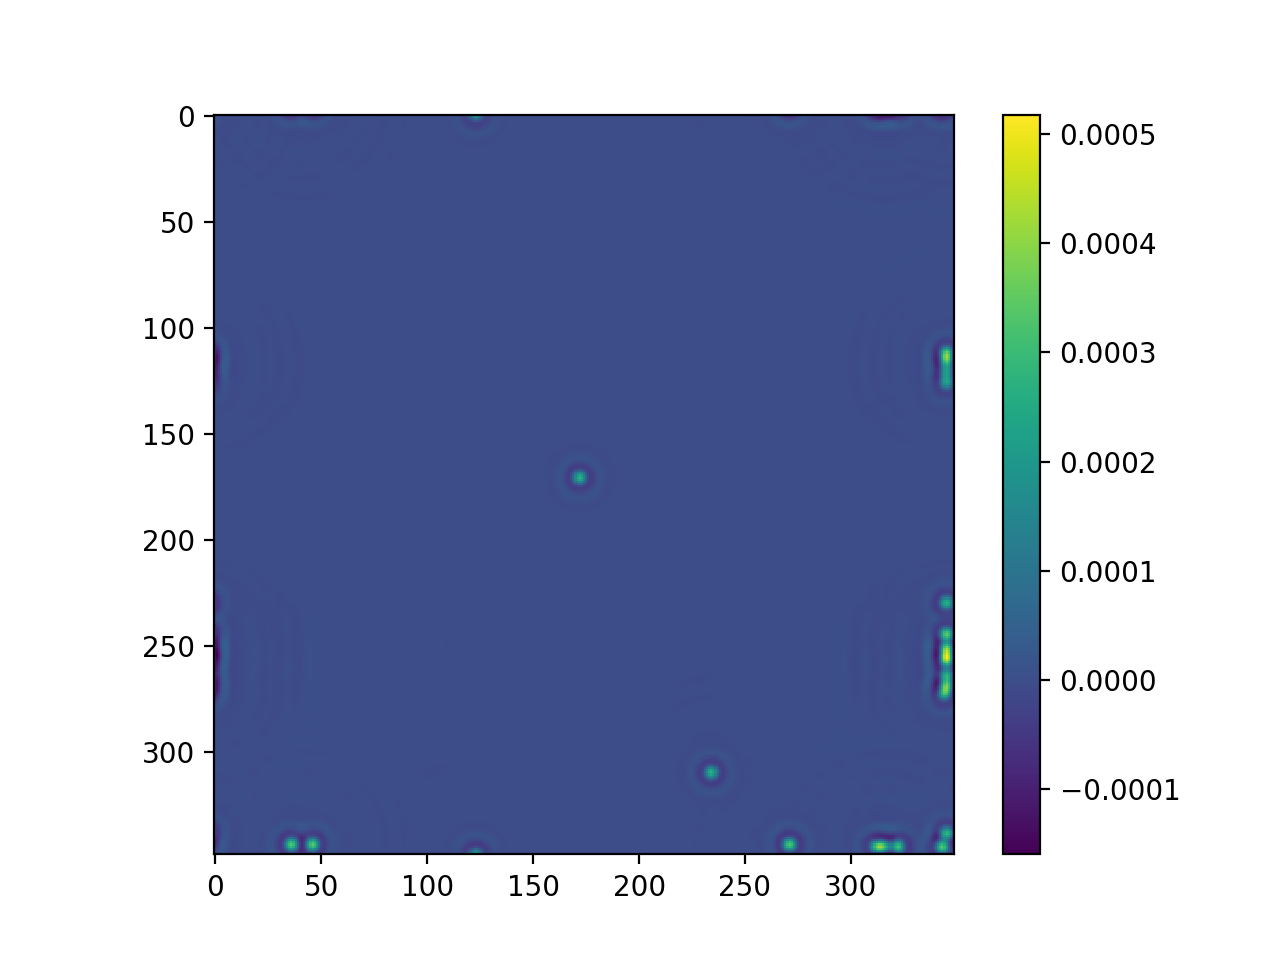

In [50]:
idx=60

pmmf.emask=ymsr.gm.return_edge_apodized_mask(15.,20.)
fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

figure()
imshow(fdata-fdatar)
colorbar()


pmmf.emask[:,:]=1.
fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

figure()
imshow(fdata-fdatar)
colorbar()

# MMF analysis with X-ray prior on location, size and temperature of cluster

In [5]:
if run_analysis:
    pmmf.emask[:,:]=1.
    start=time.time()
    result=parallel_eval_Y500_xray_prior(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior_no_edge_mask.fits"
    fxsz_cat["xnm"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_xrayprior_no_edge_mask.fits"
    fxsz_cat["xnm"]=ymsr.read_catalogue(filename=filename)

if run_analysis:
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    start=time.time()
    result=parallel_eval_Y500_xray_prior(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior_apo_edge_mask.fits"
    fxsz_cat["x"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_xrayprior_apo_edge_mask.fits"
    fxsz_cat["x"]=ymsr.read_catalogue(filename=filename)

# MMF analysis with X-ray prior on location, size and temperature of cluster - iterative noise estimation

In [6]:
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    result=parallel_eval_Y500_xray_prior_iterative(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior_iterative_apo_edge_mask.fits"
    fxsz_cat["xi"]=ymsr.write_catalogue(result,filename)
else:
    filename="ysz_cat_xrayprior_iterative_apo_edge_mask.fits"
    fxsz_cat["xi"]=ymsr.read_catalogue(filename=filename)
    
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=1.
    result=parallel_eval_Y500_xray_prior_iterative(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior_iterative_no_edge_mask.fits"
    fxsz_cat["xinm"]=ymsr.write_catalogue(result,filename)
else:
    filename="ysz_cat_xrayprior_iterative_no_edge_mask.fits"
    fxsz_cat["xinm"]=ymsr.read_catalogue(filename=filename)

# Blind MMF analysis

In [7]:
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=ymsr.gm.return_edge_apodized_mask(15.,20.)
    result=parallel_eval_Y500_blind(numprocs)
    print time.time()-start

    filename="ysz_cat_blind_apo_edge_mask.fits"
    fxsz_cat["b"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_blind_apo_edge_mask.fits"
    fxsz_cat["b"]=ymsr.read_catalogue(filename=filename)
    
if run_analysis:
    start=time.time()
    pmmf.emask[:,:]=1.
    result=parallel_eval_Y500_blind(numprocs)
    print time.time()-start

    filename="ysz_cat_blind_no_edge_mask.fits"
    fxsz_cat["bnm"]=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_blind_no_edge_mask.fits"
    fxsz_cat["bnm"]=ymsr.read_catalogue(filename=filename)

# Results

## Figures for null tests

In [8]:
anatype=["x","xnm","xi","xinm","b","bnm"]
clr=["m","r","g","b","c","brown"]
#clr=['#e6194b', '#3cb44b','#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000','#ffe119',]
labels={}
labels["x"]="X-ray prior"
labels["xnm"]="X-ray prior (NEM)"
labels["xi"]="X-ray prior iterative"
labels["xinm"]="X-ray prior iterative (NEM)"
labels["b"]="Blind"
labels["bnm"]="Blind (NEM)"

<IPython.core.display.Javascript object>


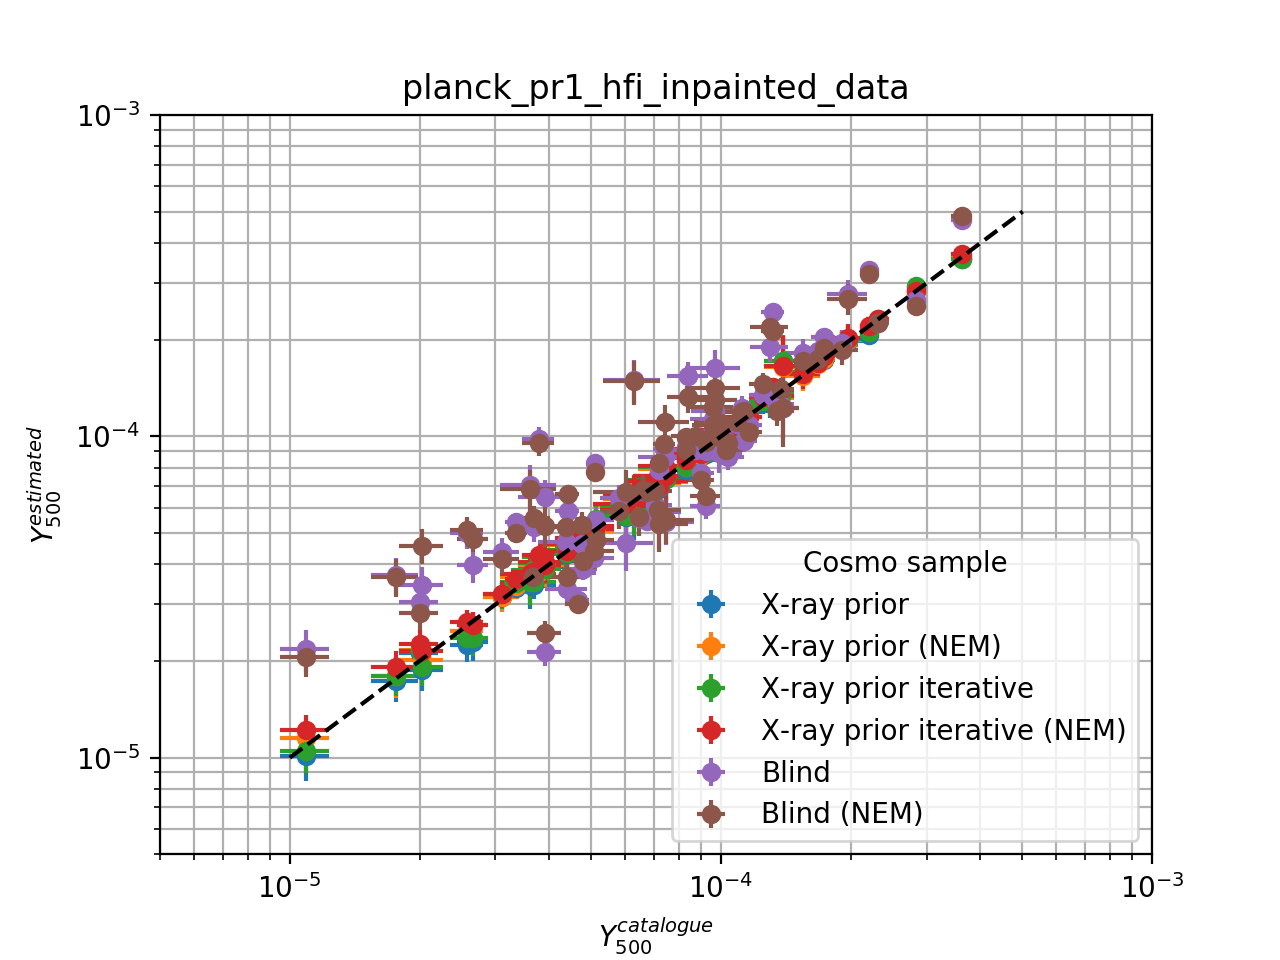

In [509]:
x=logspace(-5,-3.3,100)
figure()
for atype in anatype:
    lbl=labels[atype]
    errorbar(xsz_cat["YSZ_500"],fxsz_cat[atype]["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=fxsz_cat[atype]["YSZ_500_err"],fmt="o",label=lbl)

plot(x,x,"k--",zorder=10)
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
legend(loc=0,title="Cosmo sample")
title(figstamp)
if save_results:
    figname=figpath + "compare_Y500.pdf"
    savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


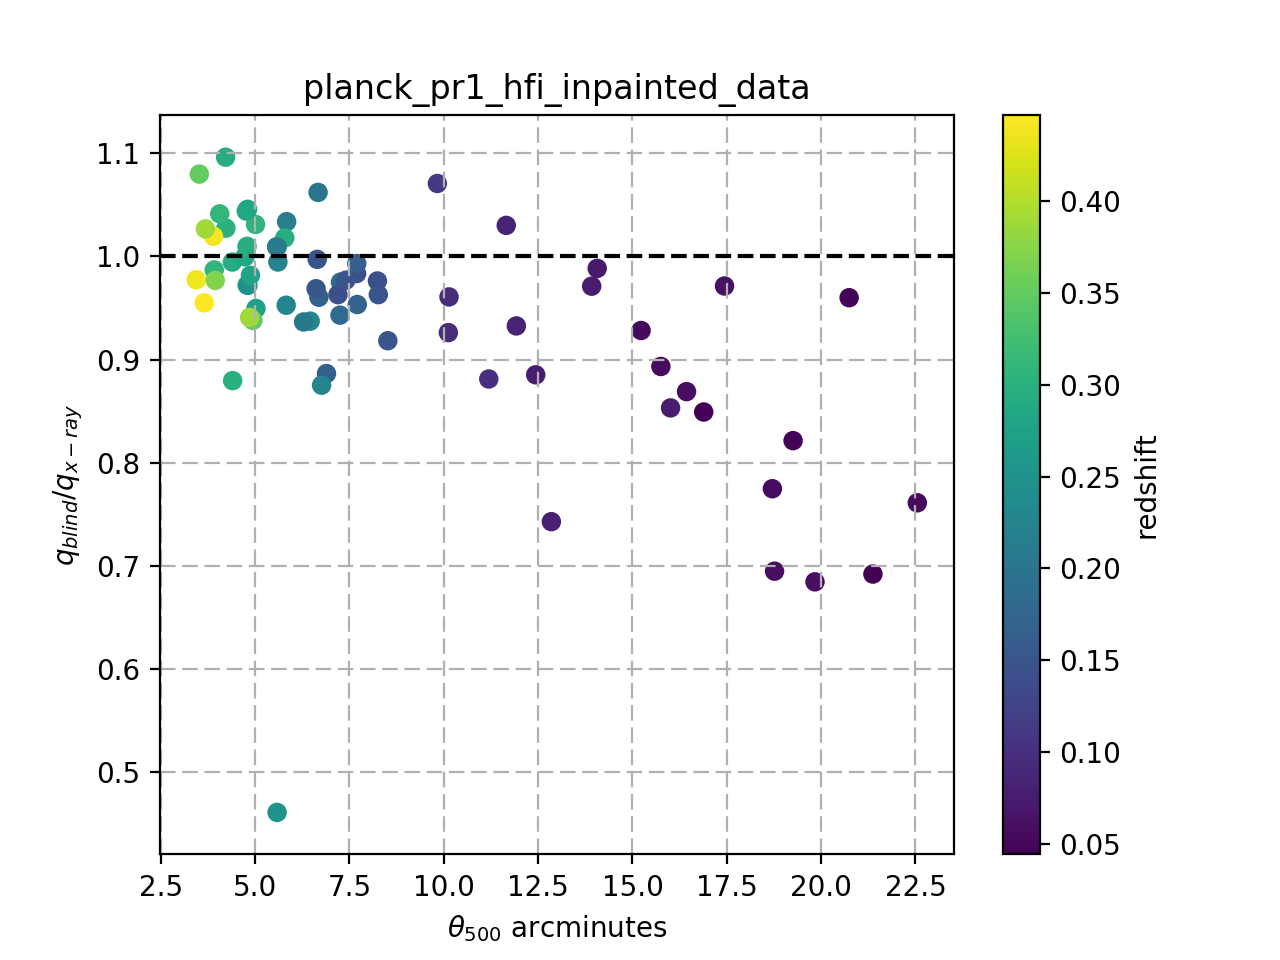

<IPython.core.display.Javascript object>


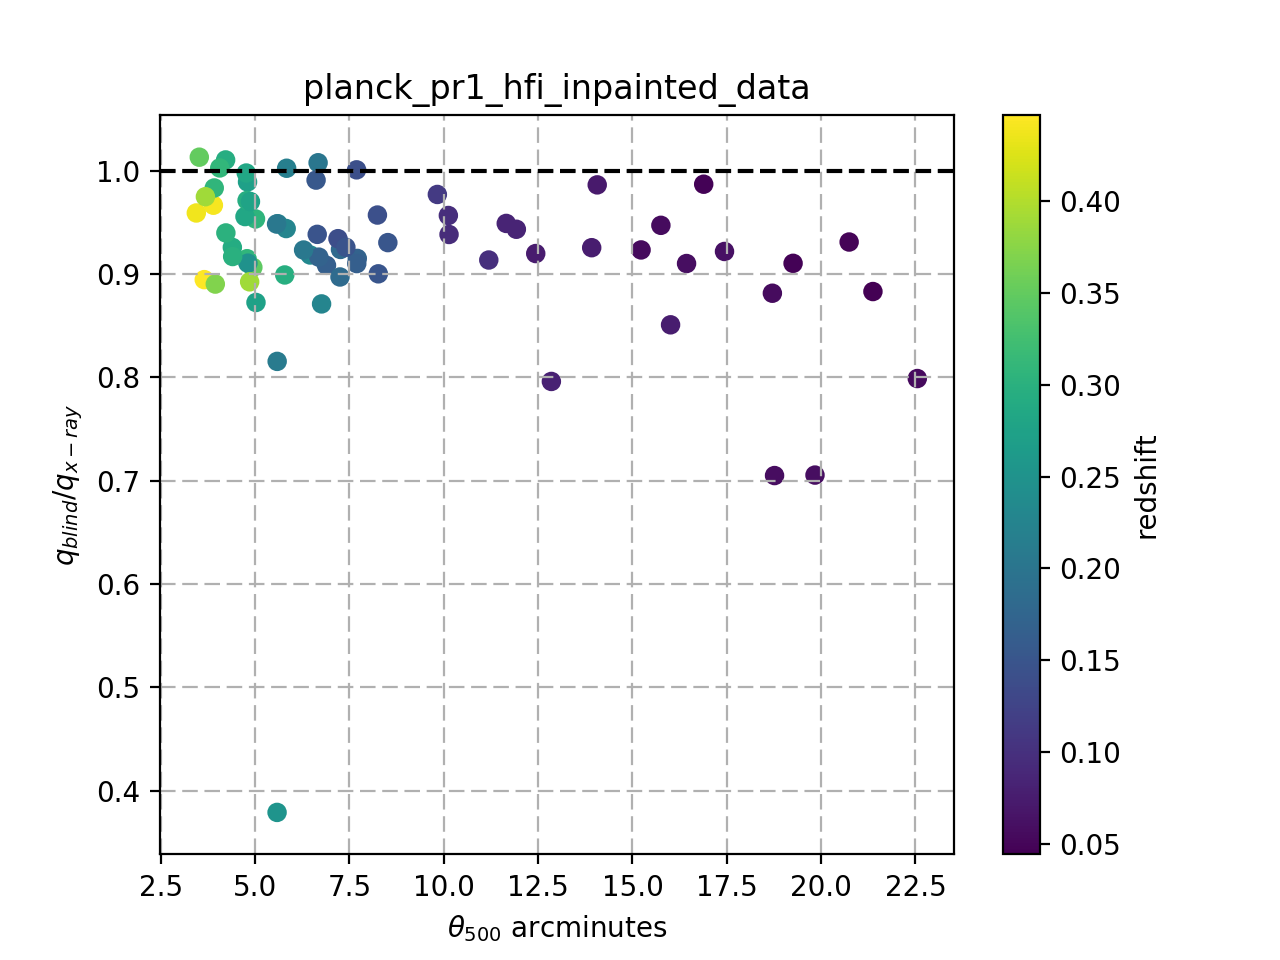

<IPython.core.display.Javascript object>


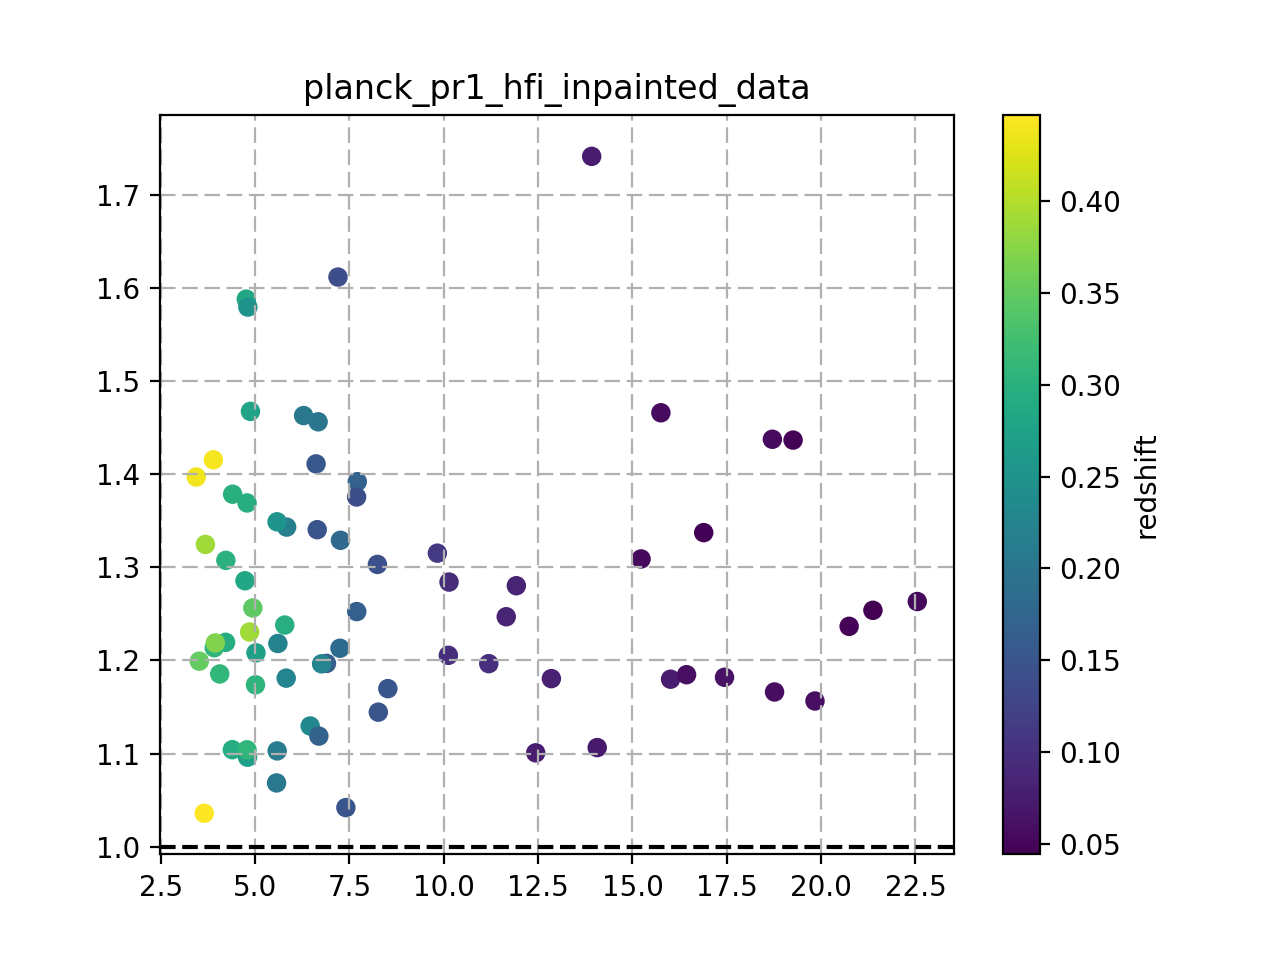

In [510]:
qcat=xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"]
qb=fxsz_cat["b"]["YSZ_500"]/fxsz_cat["b"]["YSZ_500_err"]
qbnm=fxsz_cat["bnm"]["YSZ_500"]/fxsz_cat["bnm"]["YSZ_500_err"]
qx=fxsz_cat["x"]["YSZ_500"]/fxsz_cat["x"]["YSZ_500_err"]
qxnm=fxsz_cat["xnm"]["YSZ_500"]/fxsz_cat["xnm"]["YSZ_500_err"]

figure()
scatter(xsz_cat["theta500"],qb/qcat,c=xsz_cat["z"])
colorbar(label="redshift")
ylabel(r"$q_{blind} / q_{x-ray}$")
xlabel(r"$\theta_{500}$ arcminutes")
grid(ls="--")
axhline(1,c="k",ls="--")
title(figstamp)
if save_results:
    savefig(figpath + "qblind_vs_qxray_prior.pdf",bbox_inches="tight" )
    
figure()
scatter(xsz_cat["theta500"],qbnm/qcat,c=xsz_cat["z"])
colorbar(label="redshift")
ylabel(r"$q_{blind} / q_{x-ray}$")
xlabel(r"$\theta_{500}$ arcminutes")
grid(ls="--")
axhline(1,c="k",ls="--")
title(figstamp)
if save_results:
    savefig(figpath + "qblind_vs_qxray_prior_nm.pdf",bbox_inches="tight" )
  

# Compare MMF3 q with X-ray q.
from data_preprocess import preprocess_planck_data as ppd
mmf3=ppd.get_mmf3_catalogue(snrthr=0.)

xsz_cat["mmf3q"]=np.zeros_like(xsz_cat["YSZ_500"])
xsz_cat["q"]=xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"]
for i in range(np.size(xsz_cat["YSZ_500"])):
    dglon=abs(mmf3["GLON"]-ysz_cat["GLON"][i])
    dglat=abs(mmf3["GLAT"]-ysz_cat["GLAT"][i])
    dz=abs(mmf3["REDSHIFT"]-ysz_cat["REDSHIFT"][i])
    r=np.append(np.where(dglon==min(dglon))[0],np.where(dglat==min(dglat))[0])
    r=np.append(r,np.where(dz==min(dz))[0])
    idx=np.bincount(r).argmax()
    xsz_cat["mmf3q"][i]=mmf3["SNR"][idx]
    
figure()
scatter(xsz_cat["theta500"],xsz_cat["mmf3q"]/xsz_cat["q"],c=xsz_cat["z"])
colorbar(label="redshift")
grid(ls="--")
axhline(1,c="k",ls="--")
title(figstamp)
if save_results:
    savefig(figpath + "qmmf3_vs_qxray_prior.pdf",bbox_inches="tight" )

# Difference in statistics

<IPython.core.display.Javascript object>


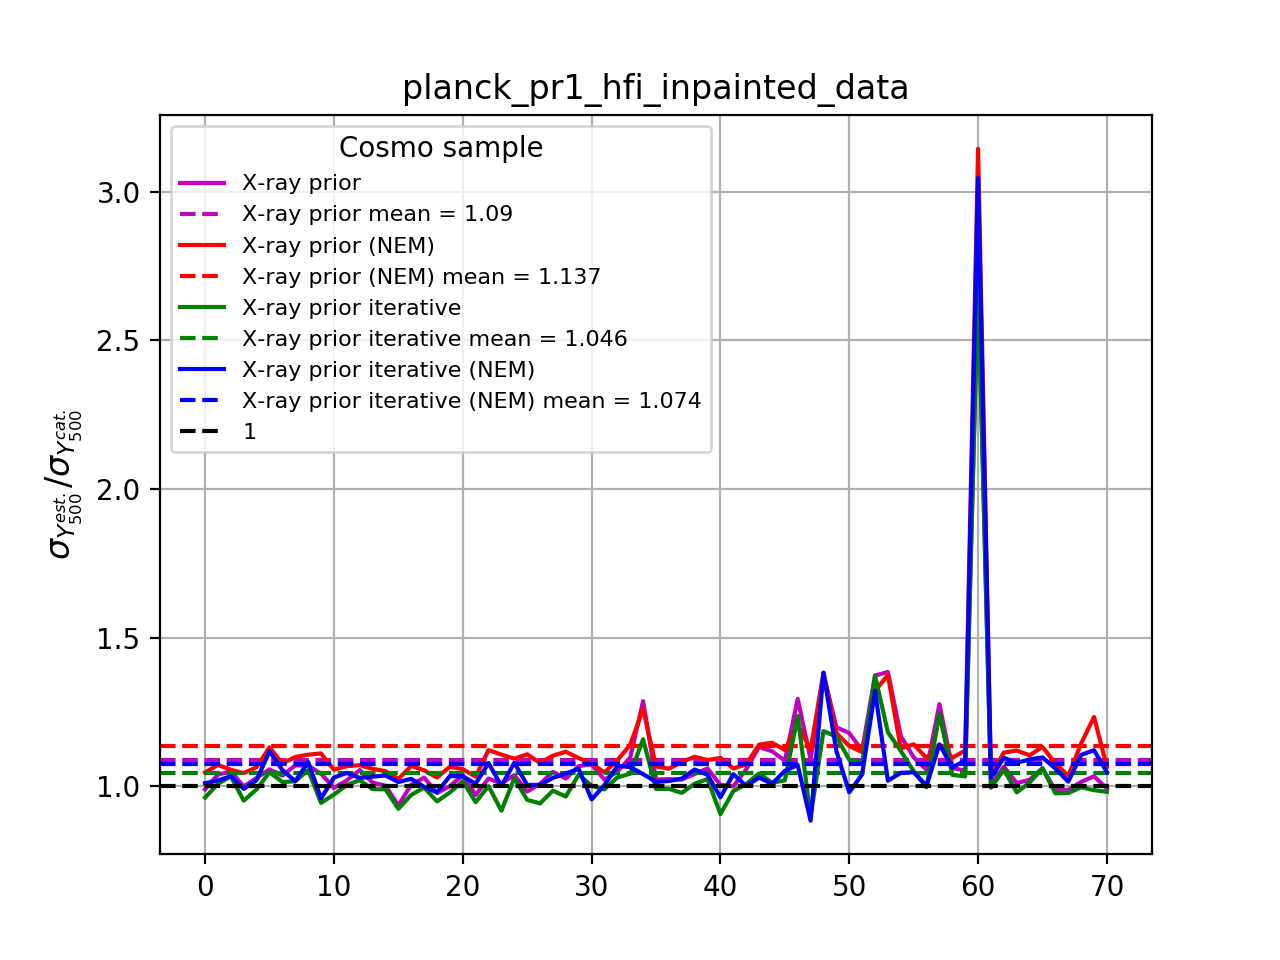

In [511]:
figure()
for ia,atype in enumerate(anatype[:4]):
        lbl=labels[atype]
        plot(fxsz_cat[atype]["YSZ_500_err"]/xsz_cat["YSZ_500_err"],label=lbl,c=clr[ia])
        mu=mean(np.array(fxsz_cat[atype]["YSZ_500_err"]/xsz_cat["YSZ_500_err"]))
        axhline(mu,label=lbl + " mean = "+ str(round(mu,3)),c=clr[ia],ls="--")

axhline(1.,ls="--",c="k",label="$1$")
legend(loc=0,title="Cosmo sample",fontsize=8)
ylabel("$\sigma_{Y^{est.}_{500}}/\sigma_{Y^{cat.}_{500}}$",fontsize=12)
#ylim(0.75,1.25)
grid()
title(figstamp)
if save_results:
    figname=figpath + "compare_Y500_err.pdf"
    savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


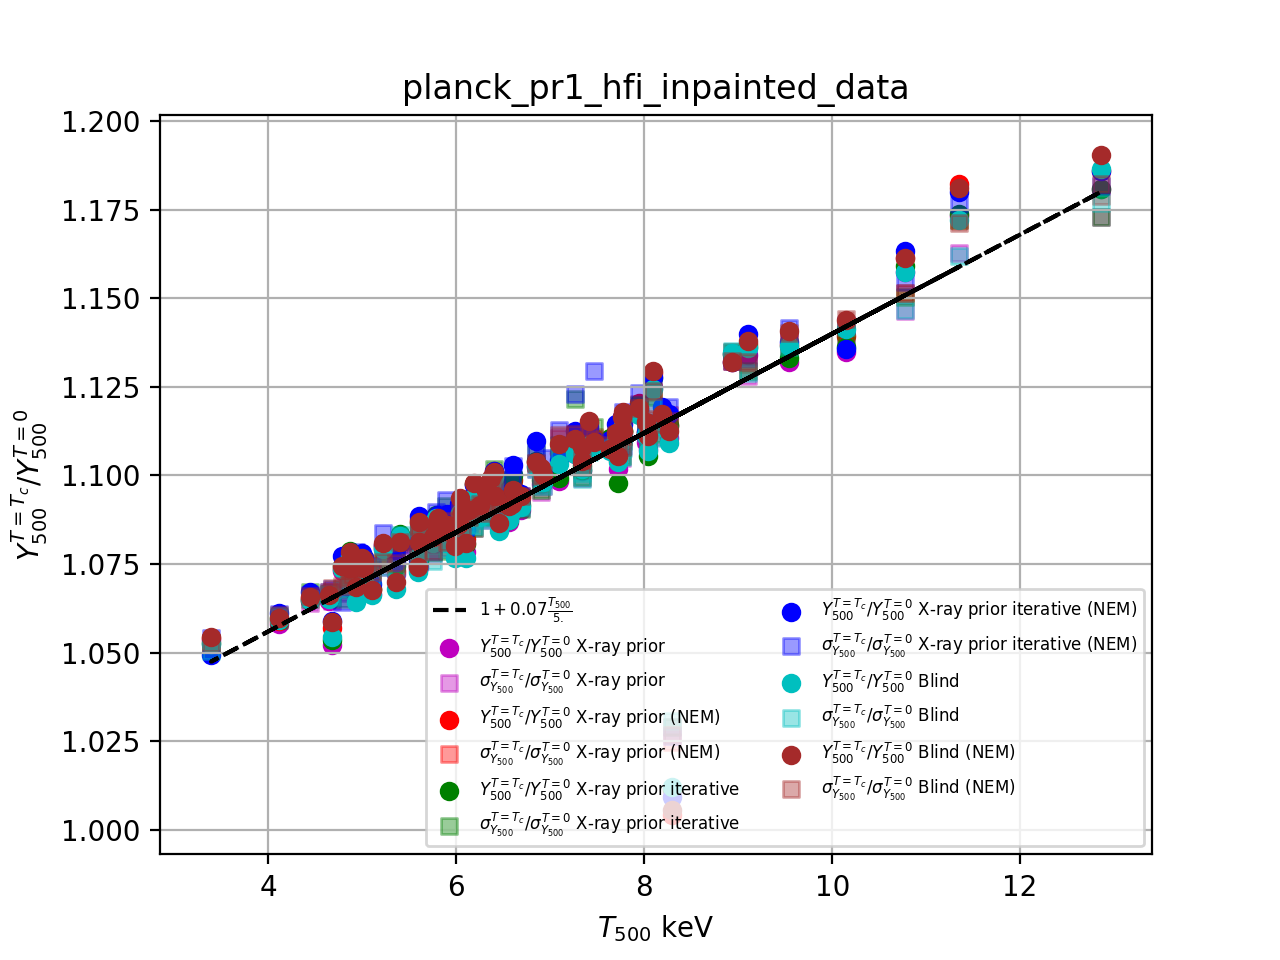

<IPython.core.display.Javascript object>


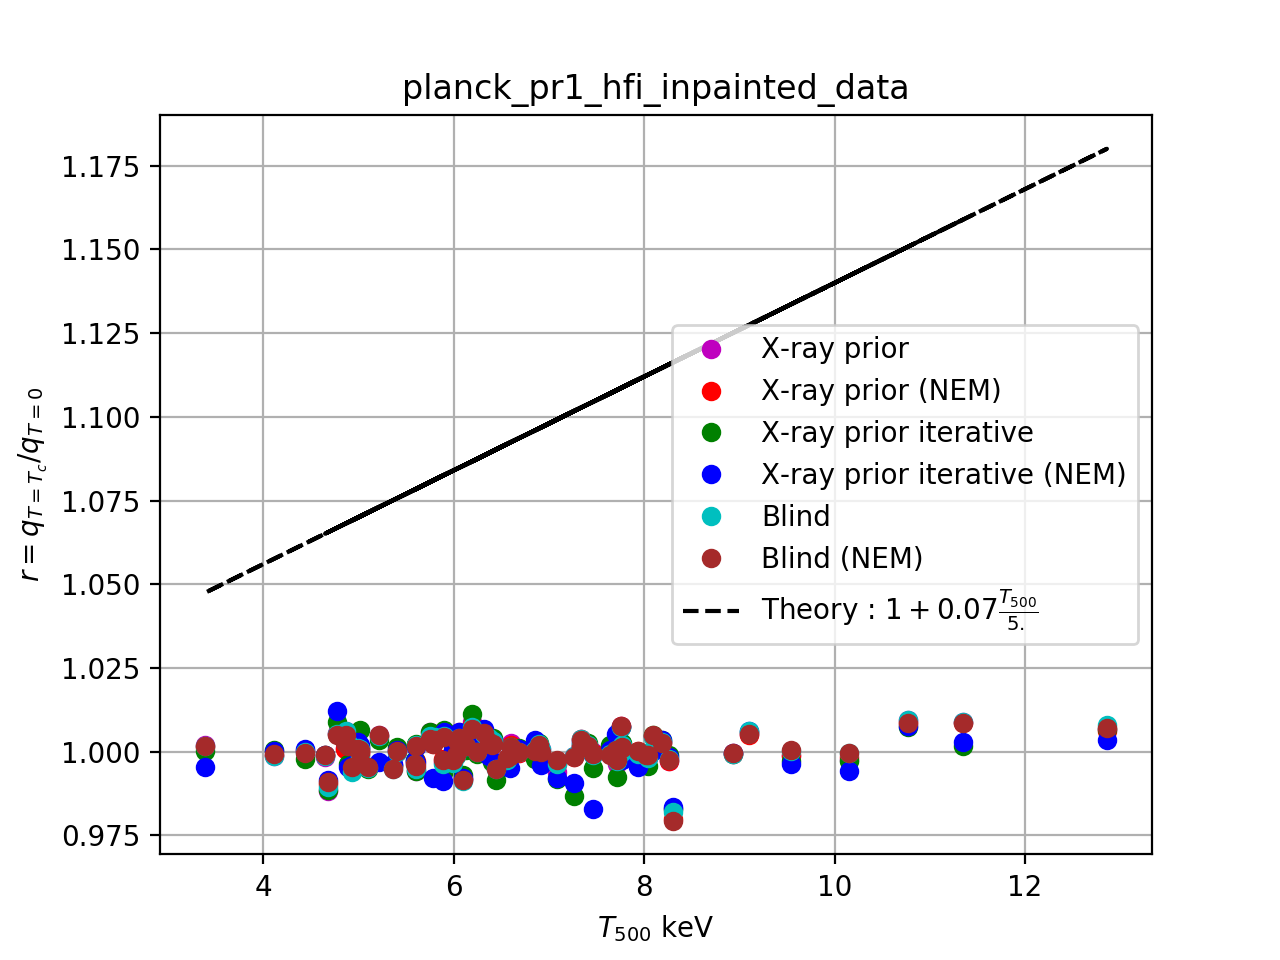

In [512]:
figure()
for ia, atype in enumerate(anatype):
    lbl="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$ " + labels[atype]
    scatter(xsz_cat["T500"],fxsz_cat[atype]["YSZ_500_Tc"]/fxsz_cat[atype]["YSZ_500"],label=lbl,c=clr[ia])
    lbl="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$ "  + labels[atype]
    scatter(xsz_cat["T500"],fxsz_cat[atype]["YSZ_500_err_Tc"]/fxsz_cat[atype]["YSZ_500_err"],label=lbl,c=clr[ia],marker="s",alpha=0.4)

plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0,fontsize=6,ncol=2)
title(figstamp)
if save_results:
    figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
    savefig(figname,bbox_inches="tight")


fn=lambda x,a: 1.+a*x/5.


figure()
for ia, atype in enumerate(anatype):
    qTT=fxsz_cat[atype]["YSZ_500_Tc"]/fxsz_cat[atype]["YSZ_500_err_Tc"]
    qT0=fxsz_cat[atype]["YSZ_500"]/fxsz_cat[atype]["YSZ_500_err"]
    lbl=labels[atype]
    plot(xsz_cat["T500"],qTT/qT0,"o",label=lbl,c=clr[ia])

slope=0.07
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Theory : " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
title(figstamp)
if save_results:
    figname=figpath + "SNR_qT0_qTT.pdf"
    savefig(figname,bbox_inches="tight")

## Deriving $Y^{SZ}_{500} - Y^X_{500}$ scalinng law

In [59]:
# xdata=log10(xsz_cat["YX_500"]/1e-4)
# xerr=return_log_err(xsz_cat["YX_500"]/1e-4,xsz_cat["YX_500_err"]/1e-4)

# # Catalogue
# ydata=log10(xsz_cat["YSZ_500"])
# yerr=return_log_err(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])
# acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print acat[3],erracat[3],bcat[3],errbcat[3]


# # T=0
# ydata=log10(fxsz_cat["YSZ_500"])
# yerr=return_log_err(fxsz_cat["YSZ_500"],fxsz_cat["YSZ_500_err"])
# aT0,bT0,erraT0,errbT0,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aT0[3],erraT0[3],bT0[3],errbT0[3]

# # T=T_c
# ydata=log10(fxsz_cat["YSZ_500_Tc"])
# yerr=return_log_err(fxsz_cat["YSZ_500_Tc"],fxsz_cat["YSZ_500_err_Tc"])
# aTT,bTT,erraTT,errbTT,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),100000)
# print aTT[3],erraTT[3],bTT[3],errbTT[3]

In [60]:
# figure()
# errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
# errorbar(xsz_cat["YX_500"]+0.02*xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
# tempx=linspace(5e-6,5e-3,1000)
# lbl="$A_{cat}$ = " + str(round(bcat[3],2)) + "$\pm$" + str(round(errbcat[3],3)) 
# lbl=lbl + " ; $B_{cat}$ = " +str(round(acat[3],2))  + "$\pm$" + str(round(erracat[3],3))
# plot(tempx,(10.**bcat[3])*(tempx/1e-4)**acat[3],label=lbl,zorder=1)

# lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
# lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
# plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)
# ylim(5e-6,1e-3)
# xlim(5e-6,1e-3)
# loglog()
# legend(loc=0)
# ylabel("$Y^{SZ}_{500}$",fontsize=10)
# xlabel("$Y^X_{500}$",fontsize=10)
# grid(which="both",alpha=0.4)
# figname=figpath + "YSZ500_YX500_cat_vs_est.pdf"
# savefig(figname,bbox_inches="tight")

In [61]:
# figure()
# errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
# errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err_Tc"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
# tempx=linspace(5e-6,5e-3,1000)
# lbl="$A_{T=0}$ = " + str(round(bT0[3],2)) + "$\pm$" + str(round(errbT0[3],3)) 
# lbl=lbl + " ; $B_{T=0}$ = " +str(round(aT0[3],2))  + "$\pm$" + str(round(erraT0[3],3))
# plot(tempx,(10.**bT0[3])*(tempx/1e-4)**aT0[3],label=lbl,zorder=3)

# lbl="$A_{T=T_c}$ = " + str(round(bTT[3],2)) + "$\pm$" + str(round(errbTT[3],3)) 
# lbl=lbl + " ; $B_{T=T_c}$ = " +str(round(aTT[3],2))  + "$\pm$" + str(round(erraTT[3],3))
# plot(tempx,(10.**bTT[3])*(tempx/1e-4)**aTT[3],label=lbl,zorder=5)

# ylim(5e-6,1e-3)
# xlim(5e-6,1e-3)
# loglog()
# legend(loc=0)
# ylabel("$Y^{SZ}_{500}$",fontsize=10)
# xlabel("$Y^X_{500}$",fontsize=10)
# grid(which="both",alpha=0.4)
# figname=figpath + "YSZ500_YX500_T0_vs_TT.pdf"
# savefig(figname,bbox_inches="tight")

## Deriving $Y^{SZ}_{500} - M^X_{500}$ scalinng law

In [196]:
# # This produces numbers in row 2 of Table 2 from Planck early results XI (A&A 536 A11 2011)
# Ezgamma=cosmo_fn.Ez(xsz_cat["z"])**(-2./3.)
# This produces numbers in Table A.1 from Planck Collaboration: Cosmology from SZ cluster counts (2013)
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
Ezgamma=Ezgamma/xsz_cat["BIAS"]
np.random.seed(0)
xdata=log10(xsz_cat["M500"]/6.)
xerr=ymsr.return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=ymsr.return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
fitcat=np.array([acat[3],erracat[3],bcat[3],errbcat[3],covab[3]])
print fitcat

fitT0={}
for atype in anatype:
    ydata=log10(fxsz_cat[atype]["YSZ_500"]*Ezgamma) 
    yerr=ymsr.return_log_err(fxsz_cat[atype]["YSZ_500"]*Ezgamma,fxsz_cat[atype]["YSZ_500_err"]*Ezgamma)
    a,b,erra,errb,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
    fitT0[atype]=np.array([a[3],erra[3],b[3],errb[3]])
    print atype,fitT0[atype]
    
fitTT={}
for atype in anatype:
    ydata=log10(fxsz_cat[atype]["YSZ_500_Tc"]*Ezgamma) 
    yerr=ymsr.return_log_err(fxsz_cat[atype]["YSZ_500_Tc"]*Ezgamma,fxsz_cat[atype]["YSZ_500_err_Tc"]*Ezgamma)
    a,b,erra,errb,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
    fitTT[atype]=np.array([a[3],erra[3],b[3],errb[3]])
    print atype,fitTT[atype]

BCES, 10000 trials... 
1.671694 s
[  1.78636777e+00   6.33764256e-02  -1.86089440e-01   1.10193684e-02
  -8.54047839e-05]
BCES, 10000 trials... 
1.684804 s
x [ 1.80166421  0.06951616 -0.18583515  0.01053425]
BCES, 10000 trials... 
1.931996 s
xnm [ 1.76783621  0.06581283 -0.18390711  0.01052471]
BCES, 10000 trials... 
1.941140 s
xi [ 1.7483462   0.06486542 -0.17170462  0.01053747]
BCES, 10000 trials... 
1.862964 s
xinm [ 1.72778679  0.06264413 -0.17150356  0.01008908]
BCES, 10000 trials... 
2.141216 s
b [ 1.69708151  0.12676614 -0.11588254  0.01752822]
BCES, 10000 trials... 
1.682329 s
bnm [ 1.66876863  0.12081345 -0.11541848  0.01691571]
BCES, 10000 trials... 
1.663050 s
x [ 1.84765407  0.06516744 -0.14607703  0.01101409]
BCES, 10000 trials... 
1.662876 s
xnm [ 1.82426982  0.06050479 -0.14399765  0.01044844]
BCES, 10000 trials... 
1.662999 s
xi [ 1.79937917  0.06312285 -0.13154045  0.01063551]
BCES, 10000 trials... 
1.658461 s
xinm [ 1.77503072  0.05978733 -0.13046045  0.00980046]
BCES

<IPython.core.display.Javascript object>


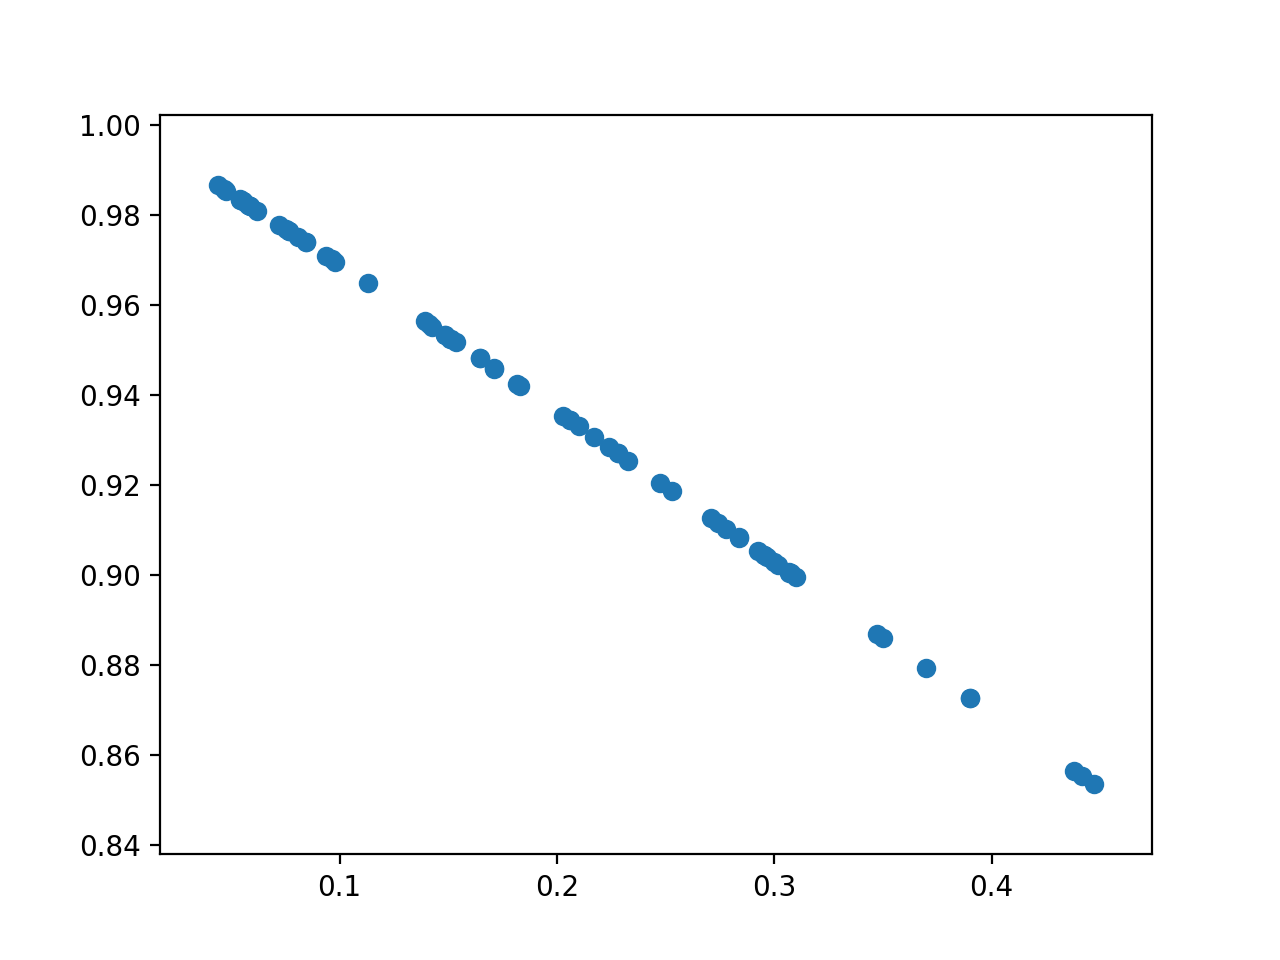

In [149]:
figure()
scatter(xsz_cat["z"],cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))

In [22]:
from scipy.special import erfc
import bces.bces as bces
import numpy as np
from contextlib import contextmanager
import sys, os


def return_Y_M_fit(YSZ_500,YSZ_500_err,M500,M500_err,redshift,qcut=6.,mbias=[],use_approx_err=True,fidx=0,verbose=False):
	np.random.seed(0)

	Ezgamma=(cosmo_fn.Ez(redshift)**(-2./3.))/1e-4
	xdata=np.log10(M500/6.)

	if use_approx_err:
		qM500=M500/M500_err
		xerr=np.log10(1. + 1./qM500)
	else:
		xerr=return_log_err(M500/6.,M500_err/6.)

	N=np.float64(np.size(YSZ_500))

	if mbias==[]:
		mbias=np.ones_like(YSZ_500,dtype=np.float64)
		ombias=np.copy(mbias)

		iteration=0
		while (np.sum(abs(mbias-ombias)/ombias/N>1.e-3) or (iteration<1)) :
			ombias=np.copy(mbias)
			ydata=np.log10(YSZ_500*Ezgamma/ombias)
			if use_approx_err:
				qY500=YSZ_500/YSZ_500_err
				yerr=np.log10(1. + 1./qY500)
			else:
				yerr=return_log_err(YSZ_500*Ezgamma/ombias,YSZ_500_err*Ezgamma/ombias)
			with suppress_stdout():
				alpha,A,alpha_err,A_err,cov_alphaA=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
			dvar=yerr**2. + (alpha[fidx]**2.)*(xerr**2.)
			w=(N/dvar)/np.sum(1./dvar)
			dmm=ydata - alpha[fidx]*xdata - A[fidx]
			var_raw=np.sum(w*(dmm**2.))/(N-2.)
			var_raw_var=(1./np.sum(1./dvar))*(N/(N-2.))
			#var_stat=np.sum(w*(yerr**2.))/(N-2.)
			#var_stat_var=np.sum(w*(yerr**2.-var_stat)**2.)/(N-2.)
			var_stat=np.mean(yerr**2.)
			var_stat_var=np.std(yerr**2.)**2.
			var_int=var_raw-var_stat
			var_int_var=var_raw_var+var_stat_var
			# See A.3.3 in Planck 2013 Cosmology with CNC
			var_int_corr=var_int + 2.*(np.cos(np.arctan(alpha[3]))**2.)*(0.05**2.)
			var=np.float64(yerr**2. + var_int)

			q=YSZ_500/YSZ_500_err
			x= -np.log10(q/qcut)
			numerator=np.exp(-x**2./(2.*var))*np.sqrt(var)
			denominator=np.sqrt(np.pi/2.)*erfc(x/np.sqrt(2.*var))
			mbias=10.**(numerator/denominator)
			iteration=iteration+1
			if verbose:
				print alpha[3],alpha_err[3],A[3],A_err[3],np.sqrt(var_raw),np.sqrt(var_int)
	else:
		ydata=np.log10(YSZ_500*Ezgamma/mbias)
		if use_approx_err:
			qY500=YSZ_500/YSZ_500_err
			yerr=np.log10(1. + 1./qY500)
		else:
			yerr=return_log_err(YSZ_500*Ezgamma/mbias,YSZ_500_err*Ezgamma/mbias)
		with suppress_stdout():
			alpha,A,alpha_err,A_err,cov_alphaA=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
		dvar=yerr**2. + (alpha[fidx]**2.)*(xerr**2.)
		w=(N/dvar)/np.sum(1./dvar)
		dmm=ydata - alpha[fidx]*xdata - A[fidx]
		var_raw=np.sum(w*(dmm**2.))/(N-2.)
		var_raw_var=(1./np.sum(1./dvar))*(N/(N-2.))
		var_stat=np.mean(yerr**2.)
		var_stat_var=np.std(yerr**2.)
		var_int=var_raw-var_stat
		var_int_var=var_raw_var+var_stat_var
		# See A.3.3 in Planck 2013 Cosmology with CNC
		var_int_corr=var_int + 2.*(np.cos(np.arctan(alpha[fidx]))**2.)*(0.05**2.)
		if verbose:
			print alpha[3],alpha_err[3],A[3],A_err[3],np.sqrt(var_raw),np.sqrt(var_int)

	result={}
	result["alpha"]=alpha[3]
	result["alpha_err"]=alpha_err[3]
	result["A"]=A[3]
	result["A_err"]=A_err[3]
	result["covAalpha"]=cov_alphaA[3]
	result["sigma_raw"]=np.sqrt(var_raw)
	result["sigma_raw_err"]=np.sqrt(var_raw_var)/(2.*np.sqrt(var_raw))
	result["sigma_int"]=np.sqrt(var_int)
	result["sigma_int_err"]=np.sqrt(var_int_var)/(2.*np.sqrt(var_int))
	result["sigma_int_corr"]=np.sqrt(var_int_corr)
	result["sigma_int_corr_err"]=np.sqrt(var_int_var)/(2.*np.sqrt(var_int))
	result["sigma_stat"]=np.sqrt(var_stat)
	result["sigma_stat_err"]=np.sqrt(var_stat_var)/(2.*np.sqrt(var_stat))
	result["BIAS"]=mbias
	return result

def return_log_err(gauss_mean,gauss_err,num_samples=100000,ignore_negatives=True):
    logerr=np.zeros_like(gauss_mean)
    for idx, mu in enumerate(gauss_mean):
        x=np.random.normal(mu,gauss_err[idx],num_samples)
        if ignore_negatives:
            while np.any(x<0):
                neg_idx=np.where(x<0)[0]
                x[neg_idx]=np.random.normal(mu,gauss_err[idx],np.size(neg_idx))
        logerr[idx]=np.std(np.log10(x))
    return logerr


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


<IPython.core.display.Javascript object>


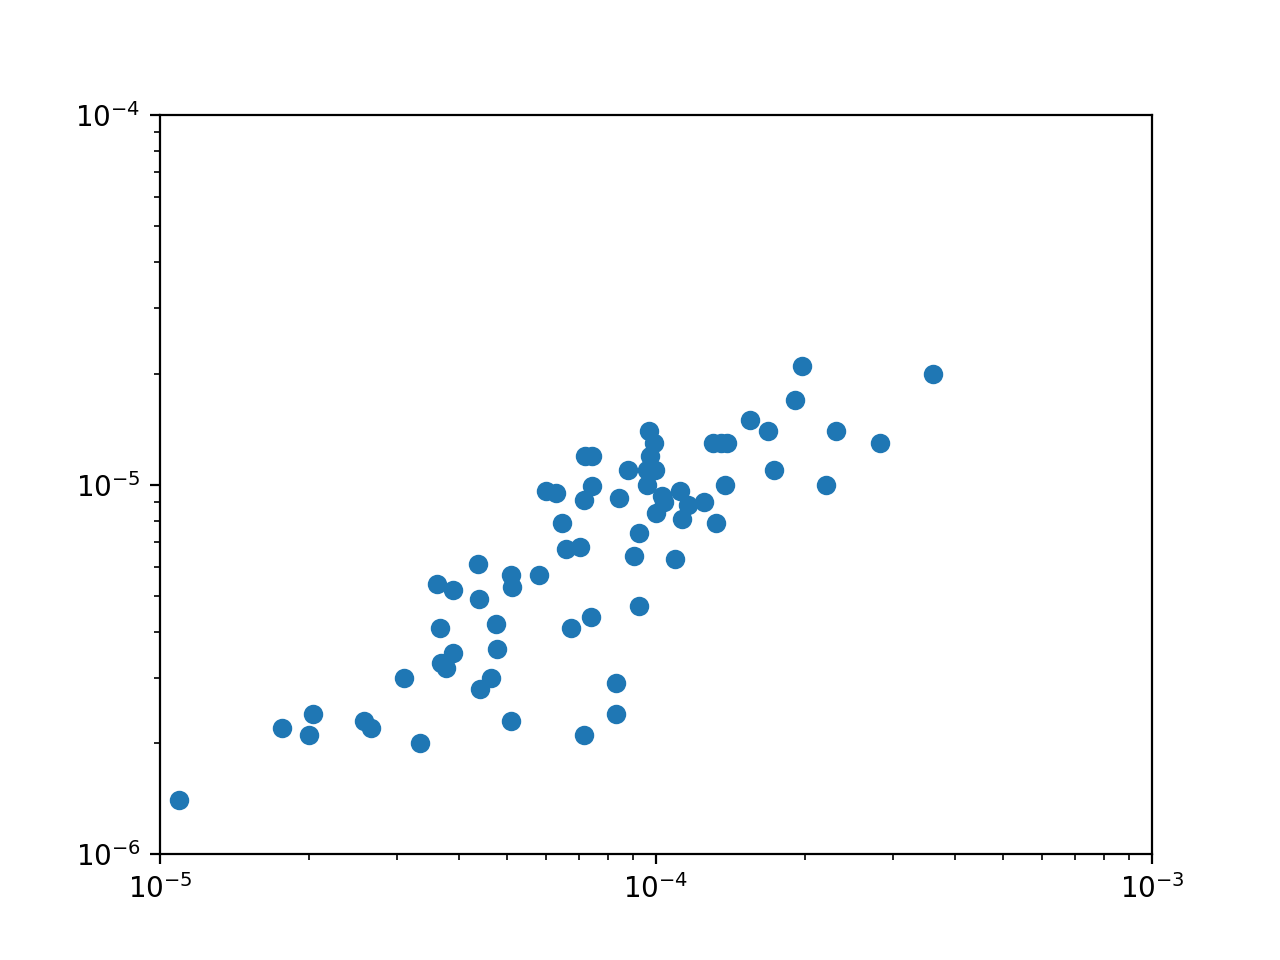

(1e-05, 0.001)

In [37]:
figure()
scatter(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"])
loglog()
ylim(1e-6,1e-4)
xlim(1e-5,1e-3)

In [27]:
fitcat0=return_Y_M_fit(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"],xsz_cat["M500"],xsz_cat["M500_err"],xsz_cat["z"],fidx=0,qcut=6.)
fitcat0

{'A': -0.18289627383831977,
 'A_err': 0.010782454680302166,
 'BIAS': array([ 1.00002125,  1.00000021,  1.00177276,  1.0023492 ,  1.00015683,
         1.00011222,  1.00000748,  1.        ,  1.00000025,  1.        ,
         1.0006246 ,  1.03223811,  1.00000137,  1.0055497 ,  1.0216696 ,
         1.1620804 ,  1.02454469,  1.00066373,  1.00644747,  1.01081155,
         1.06815309,  1.02842996,  1.        ,  1.        ,  1.00068908,
         1.00002699,  1.00745111,  1.00009592,  1.00000031,  1.0006465 ,
         1.        ,  1.00012557,  1.        ,  1.        ,  1.        ,
         1.00713557,  1.10831878,  1.00769698,  1.04891767,  1.00000015,
         1.        ,  1.00376859,  1.00013624,  1.        ,  1.        ,
         1.00000102,  1.        ,  1.00003226,  1.        ,  1.00296801,
         1.        ,  1.00011653,  1.        ,  1.        ,  1.0355134 ,
         1.02749838,  1.01518219,  1.00001733,  1.00004444,  1.18901107,
         1.00034192,  1.04273613,  1.15452051,  1.114552

<IPython.core.display.Javascript object>


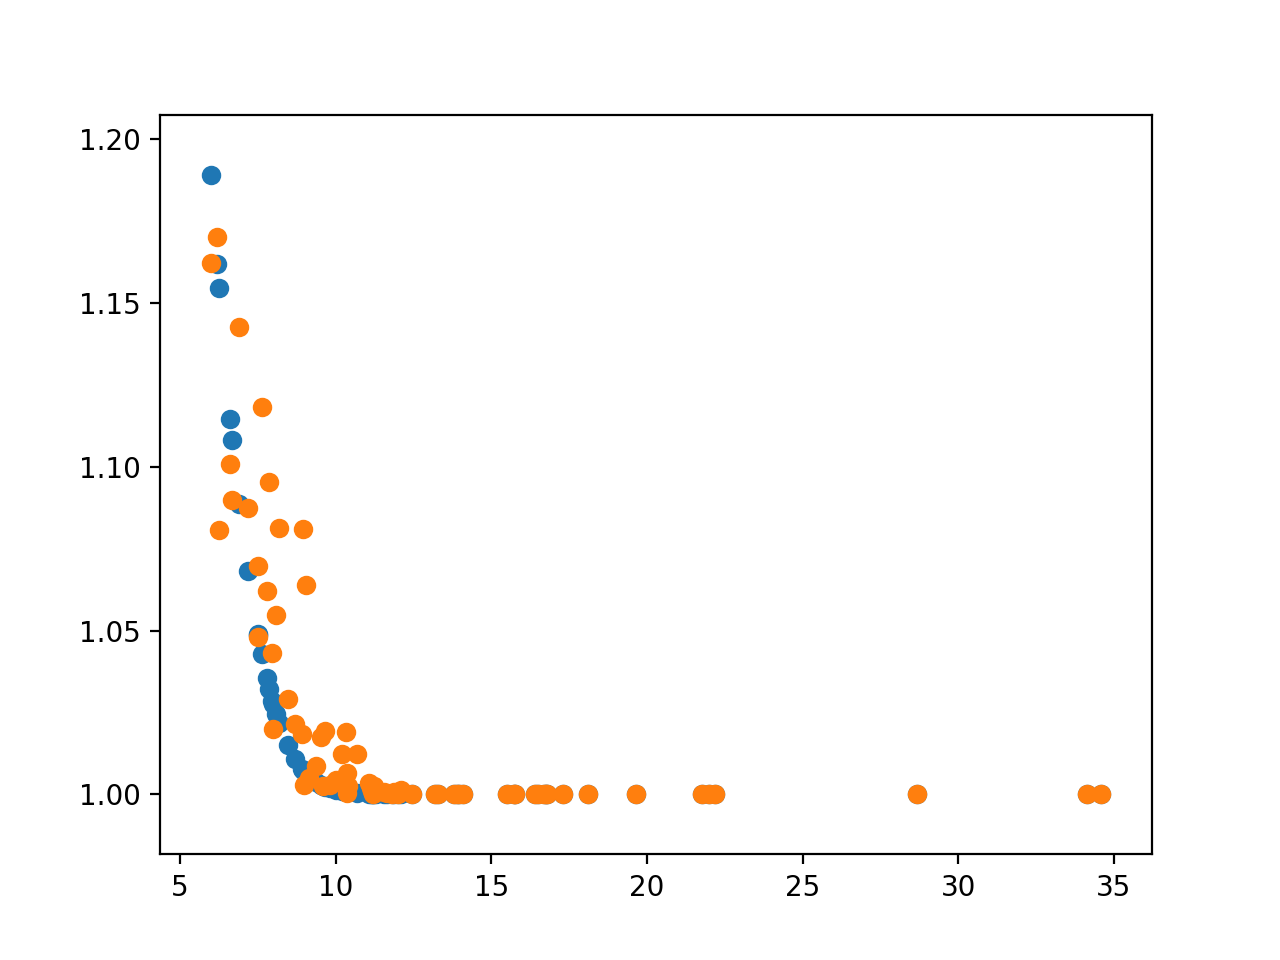

In [28]:
figure()
scatter(xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"],fitcat0["BIAS"])
scatter(xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"],xsz_cat["BIAS"])

In [20]:
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
Ezgamma=Ezgamma/xsz_cat["BIAS"]
np.random.seed(0)
xdata=log10(xsz_cat["M500"]/6.)
xerr=ymsr.return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)

# Catalogue
ydata=log10(xsz_cat["YSZ_500"]*Ezgamma)
yerr=ymsr.return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)
# ydata=log10(fxsz_cat["b"]["YSZ_500"]*Ezgamma) 
# yerr=ymsr.return_log_err(fxsz_cat["b"]["YSZ_500"]*Ezgamma,fxsz_cat[atype]["YSZ_500_err"]*Ezgamma)
acat,bcat,erracat,errbcat,covab=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
fitcat=np.array([acat[3],erracat[3],bcat[3],errbcat[3],covab[3]])

BCES, 10000 trials... 
1.612435 s


In [119]:
cov=np.zeros((2,2),float)
cov[0,0]=fitcat[1]**2.
cov[1,1]=fitcat[3]**2.
cov[0,1]=fitcat[4]
cov[1,0]=fitcat[4]
mu=np.array([fitcat[0],fitcat[2]])
print cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
alphaA=np.random.multivariate_normal(mu,cov,size=30000)

-0.122291916903


In [120]:
var_stat=np.mean(yerr**2.)
print np.sqrt(var_stat)
def return_raw_var(alpha,A):
    N=np.size(yerr)
    dvar=yerr**2. + (alpha**2.)*(xerr**2.)
    w=(N/dvar)/np.sum(1./dvar)
    dmm=(ydata - alpha*xdata - A)
    var_raw=np.sum(w*(dmm**2.))/(N-2.)
    var_raw_var=1./np.sum(1./dvar)
    var_int=var_raw-var_stat + 2.*np.cos(np.arctan(alpha))**2. * (0.05**2.)
    return var_raw,var_int,var_raw_var

0.0438403


In [121]:
sample_raw=np.zeros(np.shape(alphaA)[0],float)
sample_raw_var=np.zeros(np.shape(alphaA)[0],float)
sample_int=np.zeros(np.shape(alphaA)[0],float)
alpha=np.zeros(np.shape(alphaA)[0],float)
A=np.zeros(np.shape(alphaA)[0],float)

{'A': -0.1849218231351662,
 'A_err': 0.010487727318637912,
 'BIAS': array([ 1.00007774,  1.00000158,  1.00340404,  1.00436628,  1.00043011,
         1.0003247 ,  1.00003234,  1.00000004,  1.00000182,  1.        ,
         1.0013857 ,  1.04217798,  1.00000769,  1.00910609,  1.02967995,
         1.18312486,  1.03323411,  1.00147902,  1.01037878,  1.01616657,
         1.0823075 ,  1.03771209,  1.        ,  1.        ,  1.00149581,
         1.00009504,  1.01171652,  1.00028206,  1.00000214,  1.00143821,
         1.00000001,  1.00035772,  1.00000001,  1.        ,  1.        ,
         1.01130208,  1.12621929,  1.01203618,  1.06108419,  1.0000012 ,
         1.        ,  1.00643725,  1.0003813 ,  1.00000006,  1.        ,
         1.000006  ,  1.00000003,  1.00011122,  1.        ,  1.0052953 ,
         1.        ,  1.00033068,  1.        ,  1.        ,  1.04578399,
         1.03661694,  1.02171656,  1.00006602,  1.00014661,  1.21169279,
         1.00082642,  1.05397616,  1.17511733,  1.1327731

In [122]:
for i,x in enumerate(alphaA):
    alpha[i]=x[0] ; A[i]=x[1]
    sample_raw[i],sample_int[i],sample_raw_var[i]=return_raw_var(alpha[i],A[i])

In [123]:
def gauss(x,mu,sigma):
    x=1./sqrt(2.*pi*sigma*sigma)*exp(-(x-mu)**2./(2.*sigma*sigma))
    return x

mu_int=np.mean(np.sqrt(sample_int))
sigma_int=np.std(np.sqrt(sample_int))
xint=linspace(mu_int-3*sigma_int,mu_int+3*sigma_int,1000)
yint=gauss(xint,mu_int,sigma_int)

mu_raw=np.mean(np.sqrt(sample_raw))
sigma_raw=np.std(np.sqrt(sample_raw))
xraw=linspace(mu_raw-3*sigma_raw,mu_raw+3*sigma_raw,1000)
yraw=gauss(xraw,mu_raw,sigma_raw)

<IPython.core.display.Javascript object>


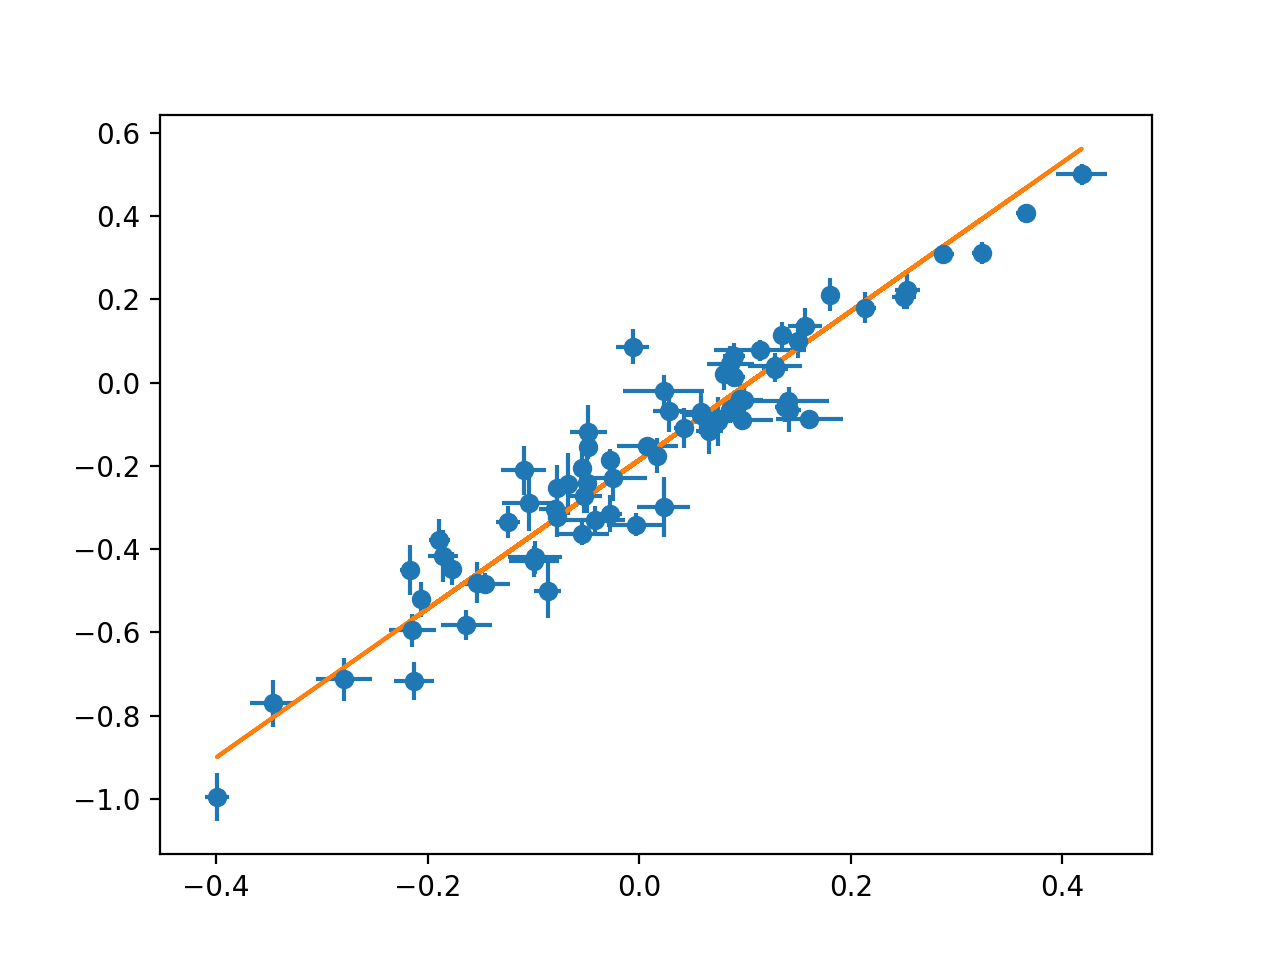

In [135]:
figure()
errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt="o")
plot(xdata,fitcat[0]*xdata+fitcat[2])

In [147]:
std(xdata)

0.15912841

In [126]:
np.std(np.sqrt(sample_raw)),np.std(sample_raw)/(2.*np.sqrt(np.mean(sample_raw)))

(0.0031778924489253642, 0.0032451474553107408)

In [128]:
np.sqrt(0.011**2. - 0.009**2.)

0.0063245553203367588

In [112]:
N=np.size(yerr)
dvar=yerr**2. + (np.mean(alpha)**2.)*(xerr**2.)
w=(N/dvar)/np.sum(1./dvar)
dmm=(ydata - np.mean(alpha)*xdata - np.mean(A))
var_raw=np.sum(w*(dmm**2.))/(N-2.)
print np.sqrt(var_raw)

0.0770033411599


In [131]:
np.std(yerr**2.)/(2.*np.sqrt(np.mean(yerr**2.)))

0.014620138033305283

In [103]:
np.sqrt(np.std(sample_raw)**2. + np.std(yerr**2.)**2.)/(2.*0.066)

0.0099617676906589171

<IPython.core.display.Javascript object>


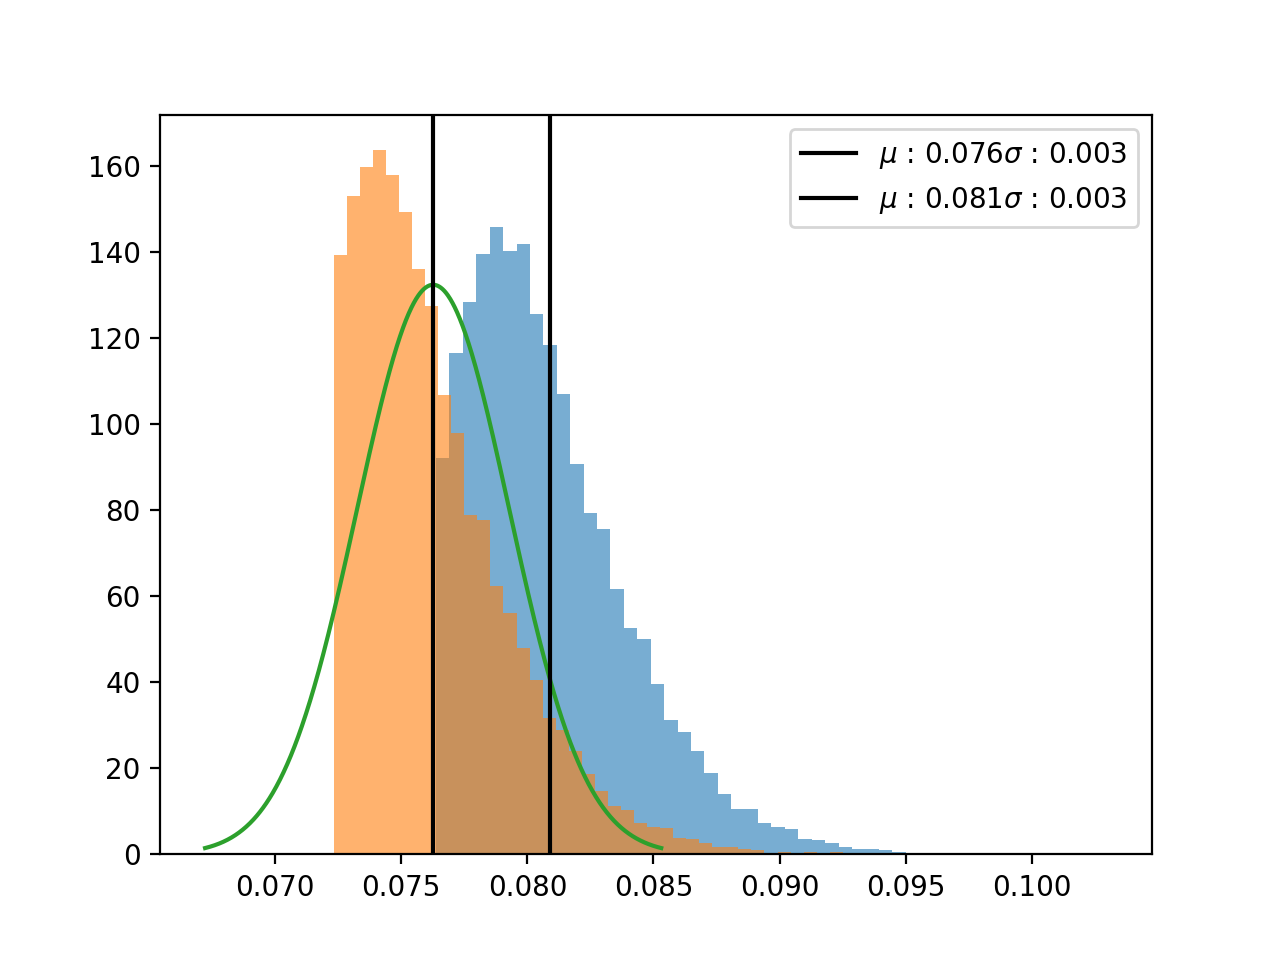

<IPython.core.display.Javascript object>


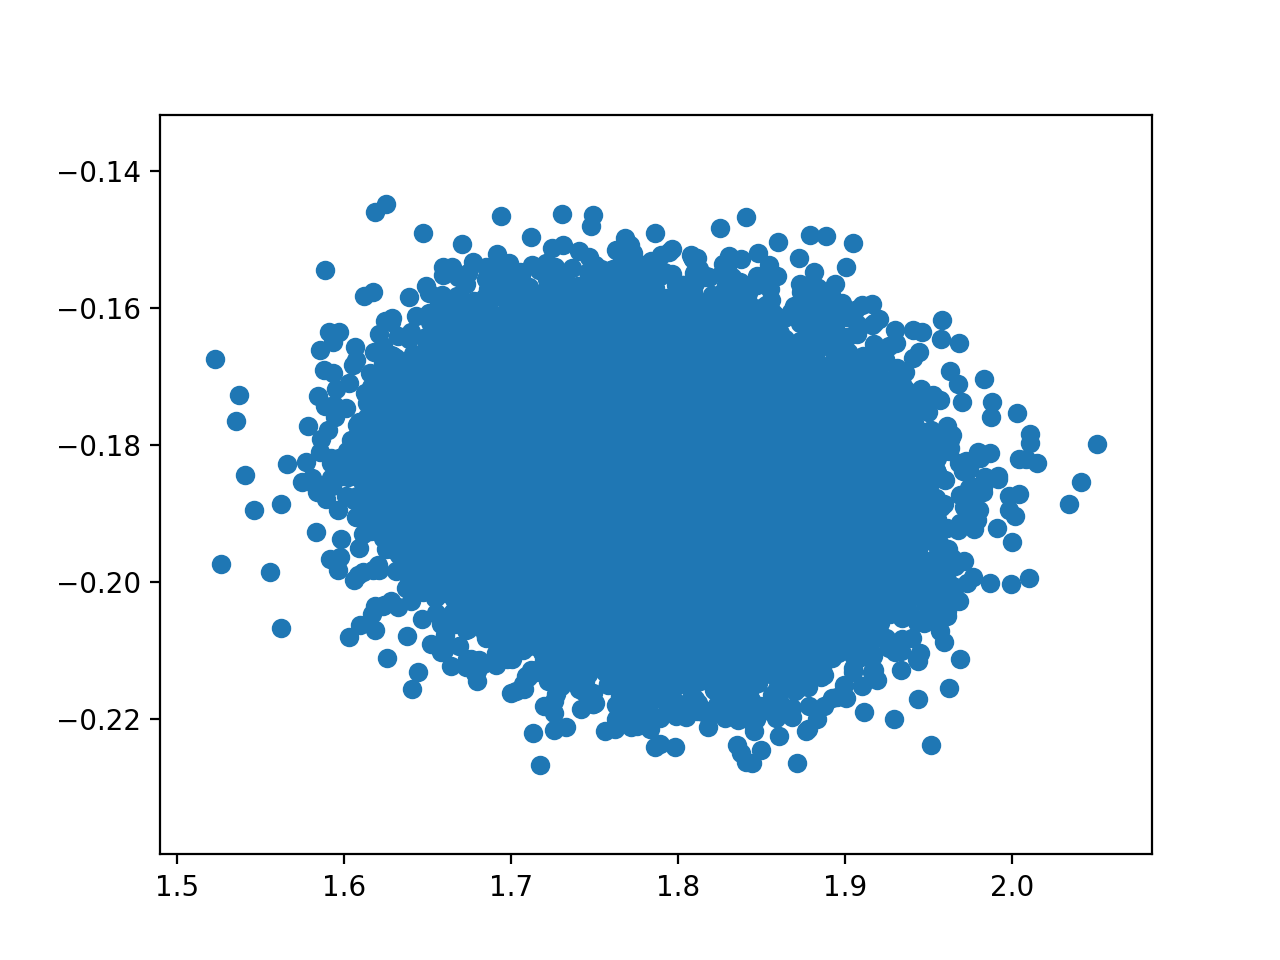

In [124]:
figure()
hist(np.sqrt(sample_raw),normed=True,alpha=0.6,bins=50)
hist(np.sqrt(sample_int),normed=True,alpha=0.6,bins=50)
plot(xint,yint)
axvline(mu_int,c="k",label=r"$\mu$ : " + str(round(mu_int,3)) + "$\sigma$ : " + str(round(sigma_int,3)))
axvline(mu_raw,c="k",label=r"$\mu$ : " + str(round(mu_raw,3)) + "$\sigma$ : " + str(round(sigma_raw,3)))
legend(loc=0)

figure()
scatter(alpha,A)

<IPython.core.display.Javascript object>


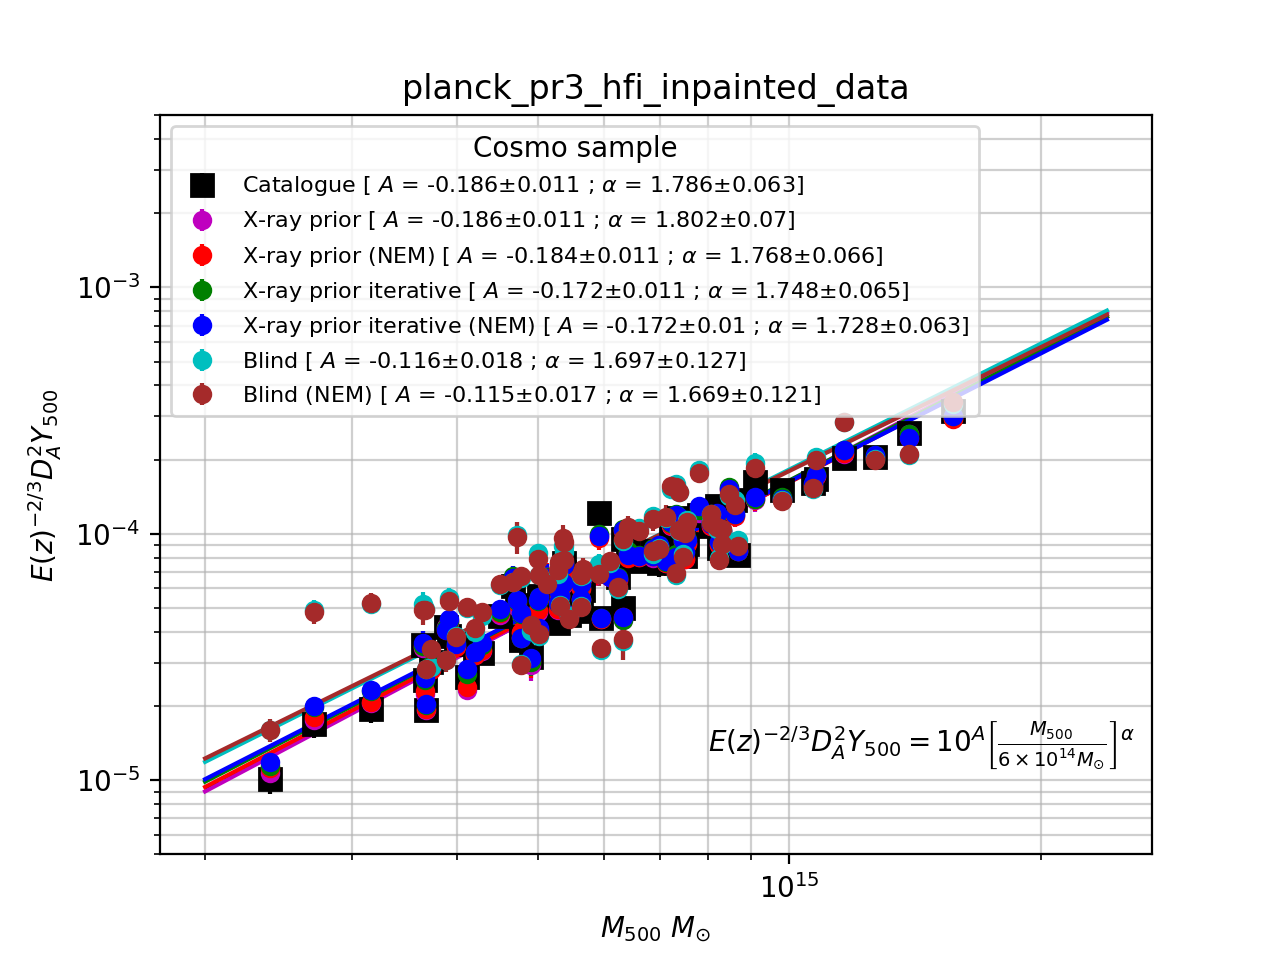

In [174]:
numdec=3
M500=linspace(2,24,1000)
norm=1e-4
figure()

lbl="Catalogue"
lbl=lbl+r" [ $A$ = " + str(round(fitcat[2],numdec)) + r"$\pm$" + str(round(fitcat[3],numdec)) 
lbl=lbl + r" ; $\alpha$ = " +str(round(fitcat[0],numdec))  + r"$\pm$" + str(round(fitcat[1],numdec)) + "]" 
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="s",c="k",markersize=8,label=lbl)
plot(M500*1e14,(10.**fitcat[2])*((M500/6.)**fitcat[0])*norm,"k--")

for ia,atype in enumerate(anatype):
    lbl=labels[atype]
    lbl=lbl + r" [ $A$ = " + str(round(fitT0[atype][2],numdec)) + r"$\pm$" + str(round(fitT0[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitT0[atype][0],numdec))  + r"$\pm$" + str(round(fitT0[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err"]*Ezgamma*norm,fmt="o",c=clr[ia],label=lbl)
    plot(M500*1e14,(10.**fitT0[atype][2])*((M500/6.)**fitT0[atype][0])*norm,c=clr[ia])

ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl="Cosmo sample"
legend(loc=0,title=lbl,fontsize=8)
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
text(8e14,1.3e-5,lbl)
ylim(5e-6,5e-3)
title(figstamp)
loglog()
grid(which="both",alpha=0.6)
if save_results:
    figname=figpath + "Y500_vs_M500_compare_with_cat.pdf"
    savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


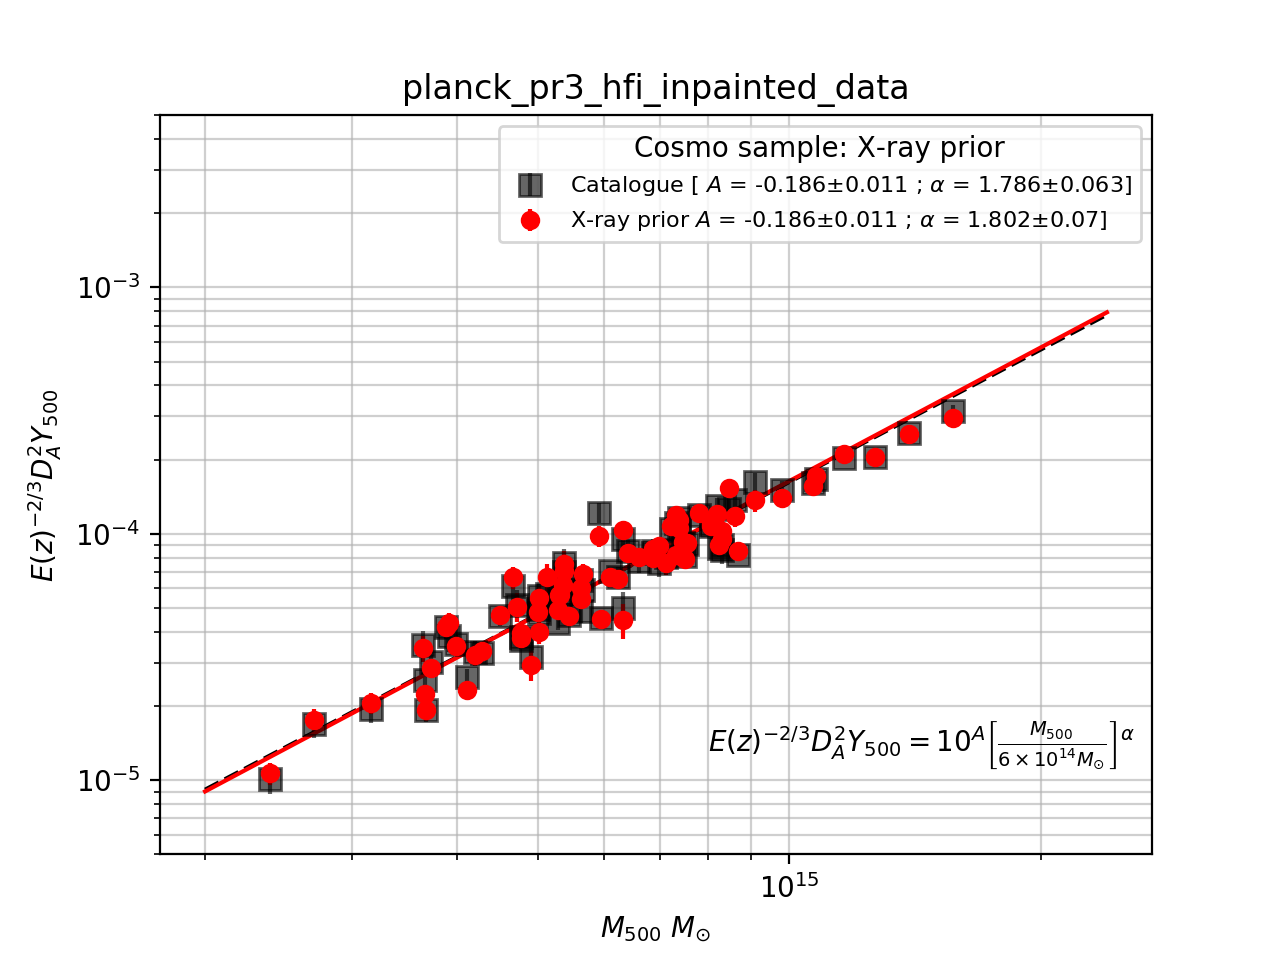

<IPython.core.display.Javascript object>


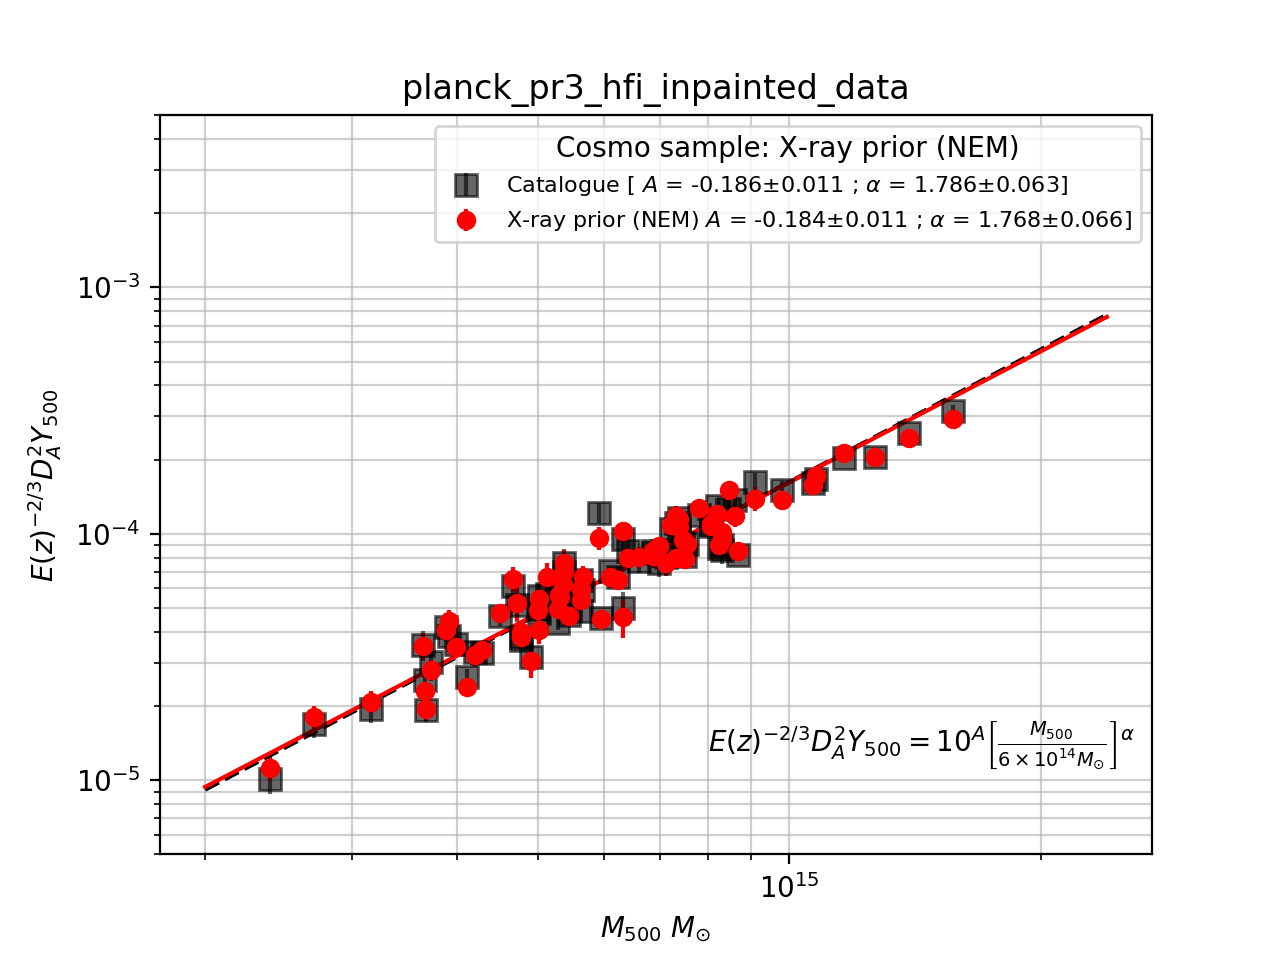

<IPython.core.display.Javascript object>


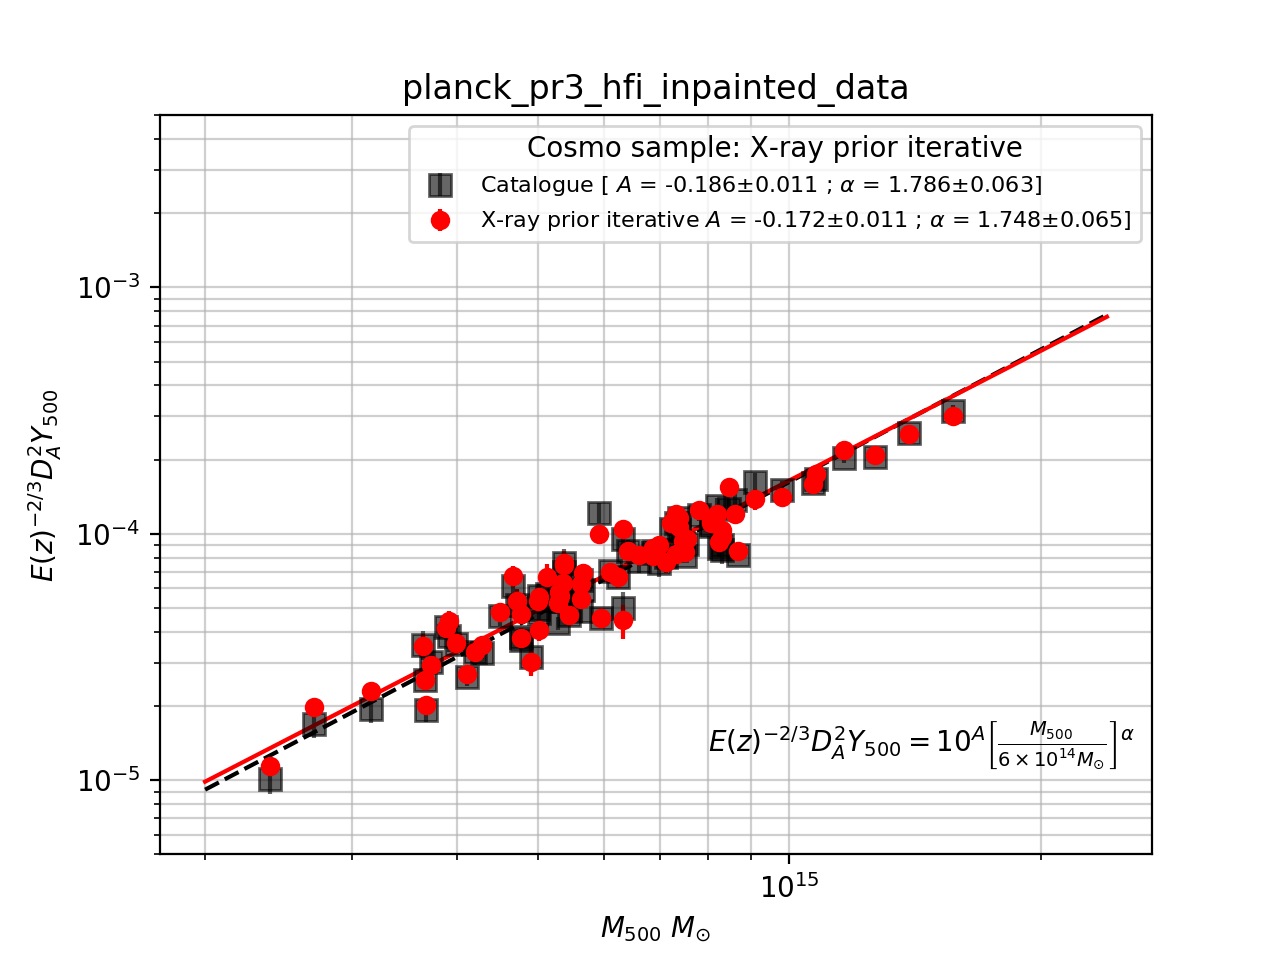

<IPython.core.display.Javascript object>


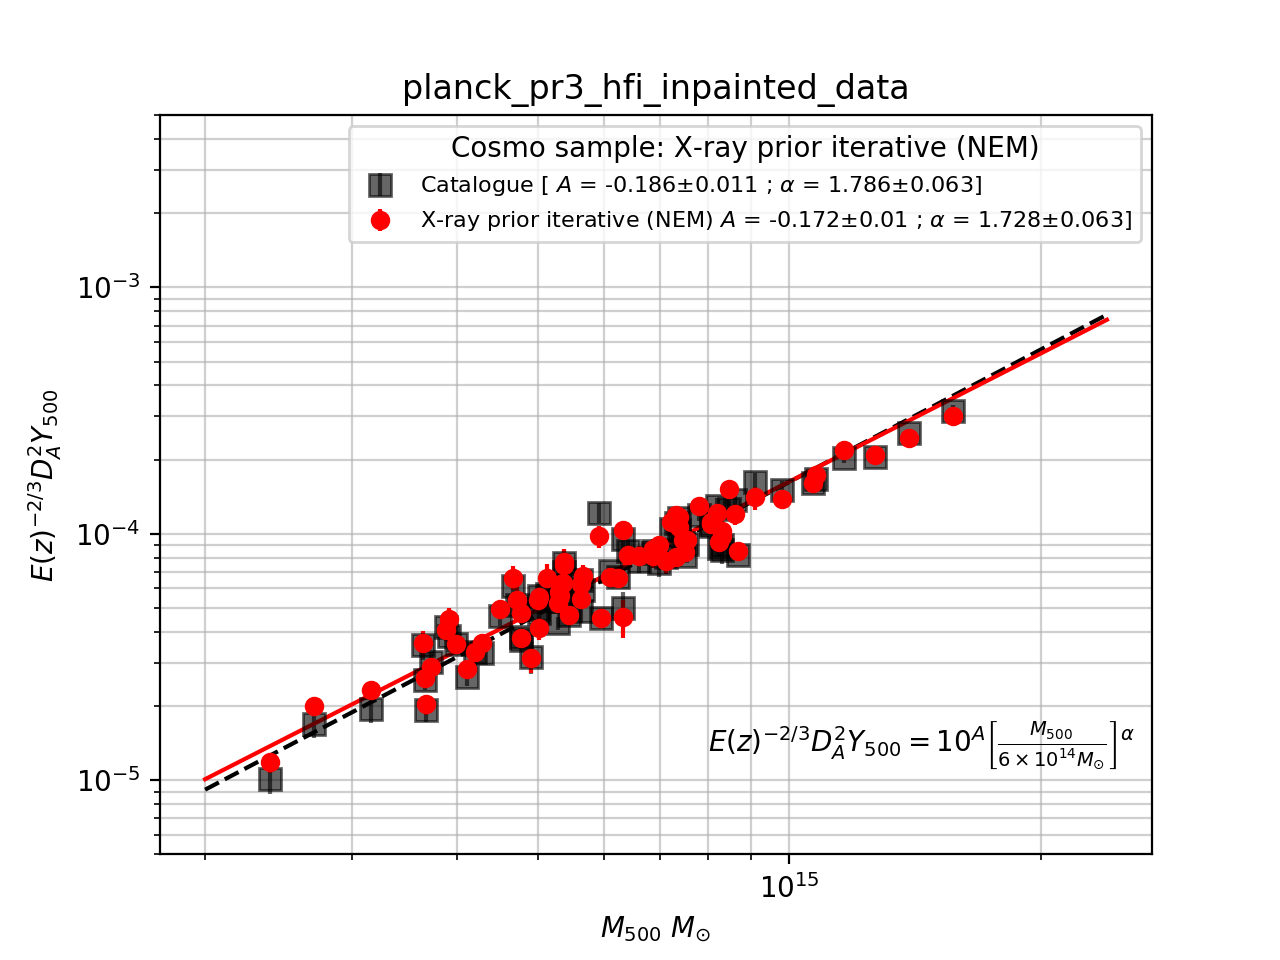

<IPython.core.display.Javascript object>


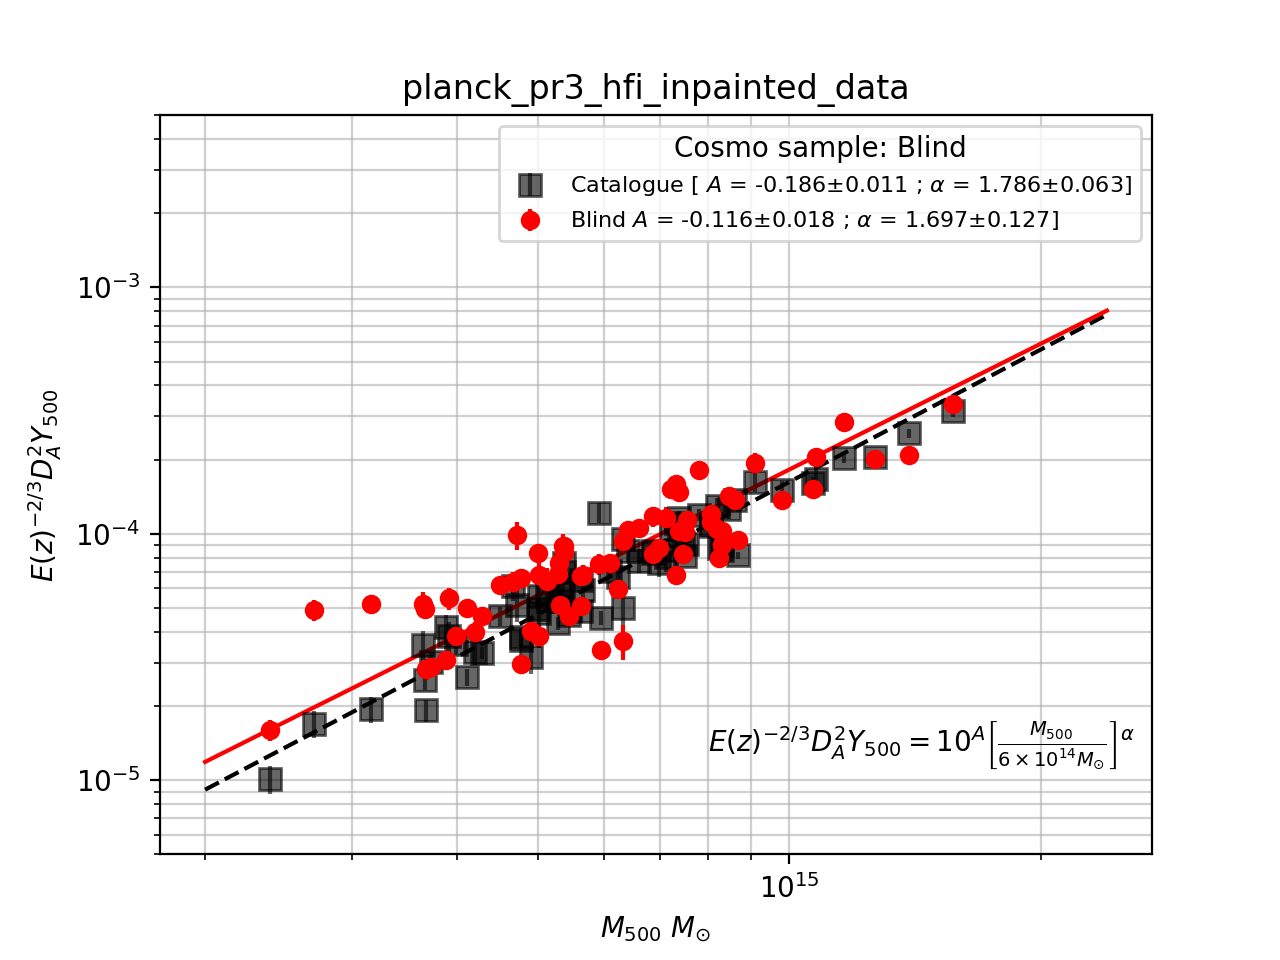

<IPython.core.display.Javascript object>


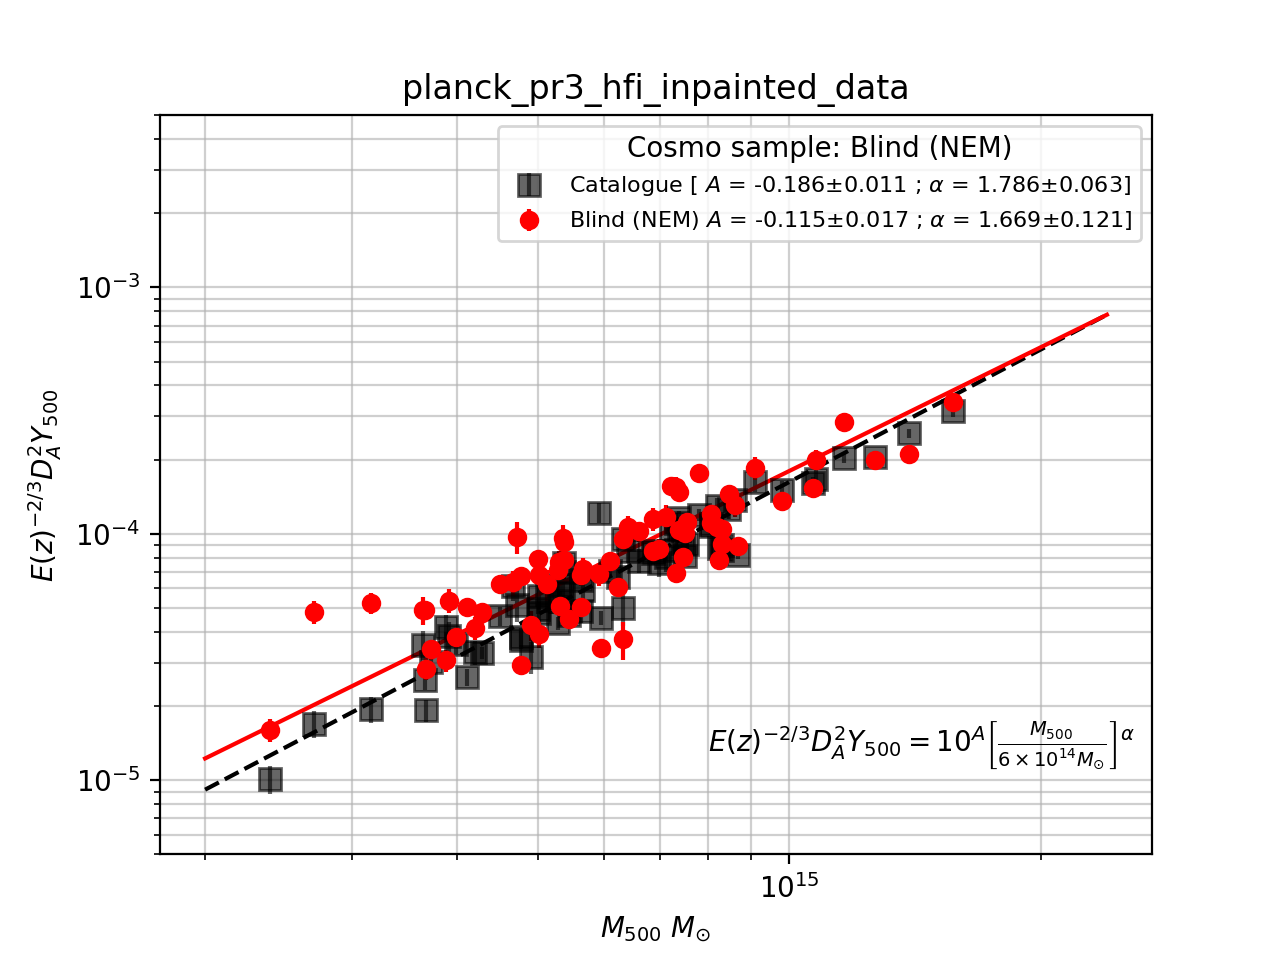

In [175]:
for ia,atype in enumerate(anatype):  
    figure()
    lbl="Catalogue"
    lbl=lbl+r" [ $A$ = " + str(round(fitcat[2],numdec)) + r"$\pm$" + str(round(fitcat[3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitcat[0],numdec))  + r"$\pm$" + str(round(fitcat[1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="s",c="k",markersize=8,label=lbl,alpha=0.6)
    plot(M500*1e14,(10.**fitcat[2])*((M500/6.)**fitcat[0])*norm,"k--")
    lbl=labels[atype]
    lbl=lbl + r" $A$ = " + str(round(fitT0[atype][2],numdec)) + r"$\pm$" + str(round(fitT0[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitT0[atype][0],numdec))  + r"$\pm$" + str(round(fitT0[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err"]*Ezgamma*norm,fmt="o",c="r",label=lbl)
    plot(M500*1e14,(10.**fitT0[atype][2])*((M500/6.)**fitT0[atype][0])*norm,c="r")
    
    ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
    xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
    lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
    text(8e14,1.3e-5,lbl)
    legend(loc=0,title="Cosmo sample: " + labels[atype],fontsize=8)
    ylim(5e-6,5e-3)
    title( figstamp)
    loglog()
    grid(which="both",alpha=0.6)
    if save_results:
        figname=figpath + "Y500_vs_M500_compare_with_cat_" + atype + ".pdf"
        savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


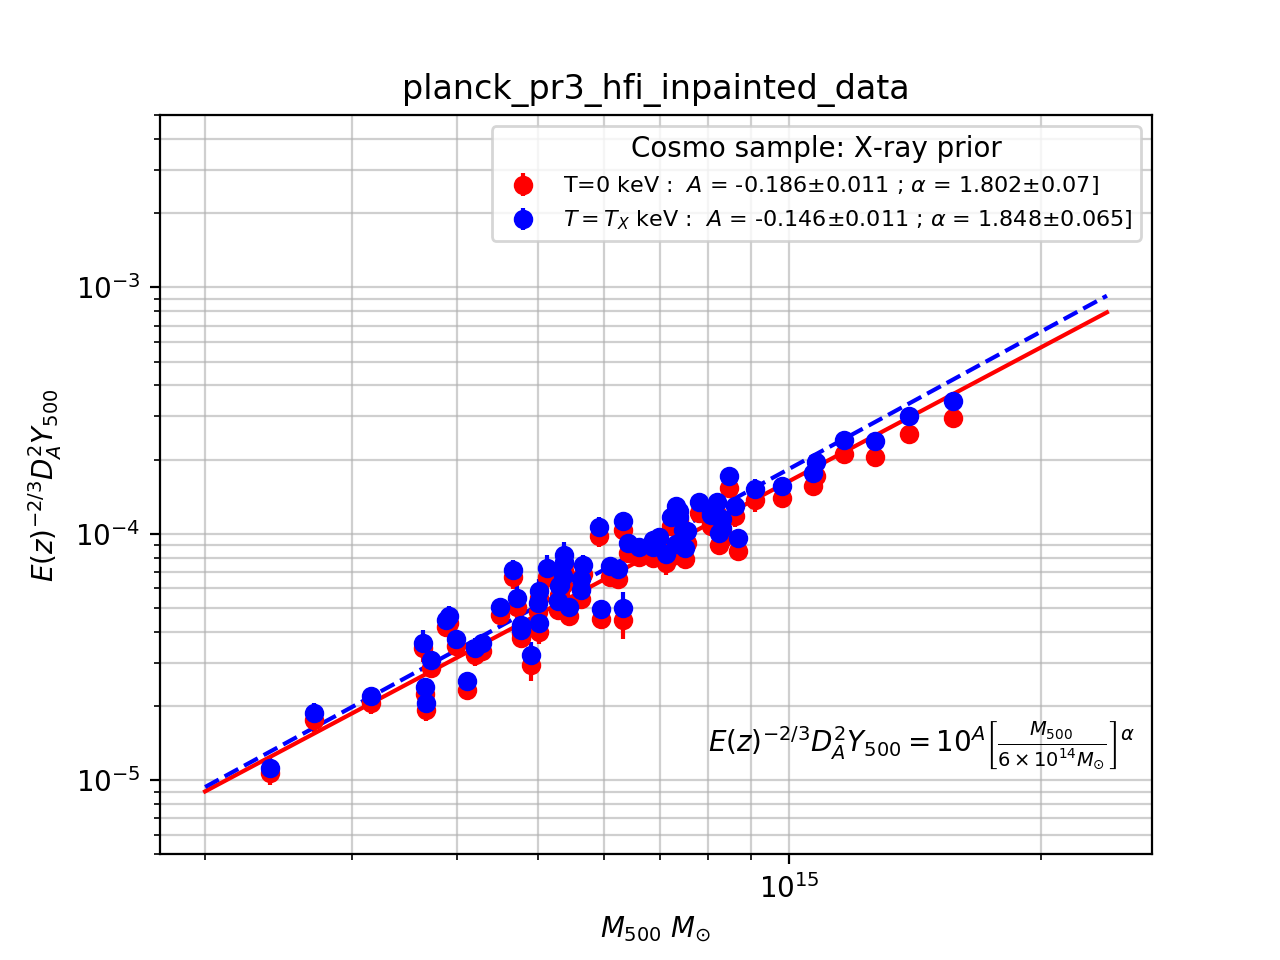

<IPython.core.display.Javascript object>


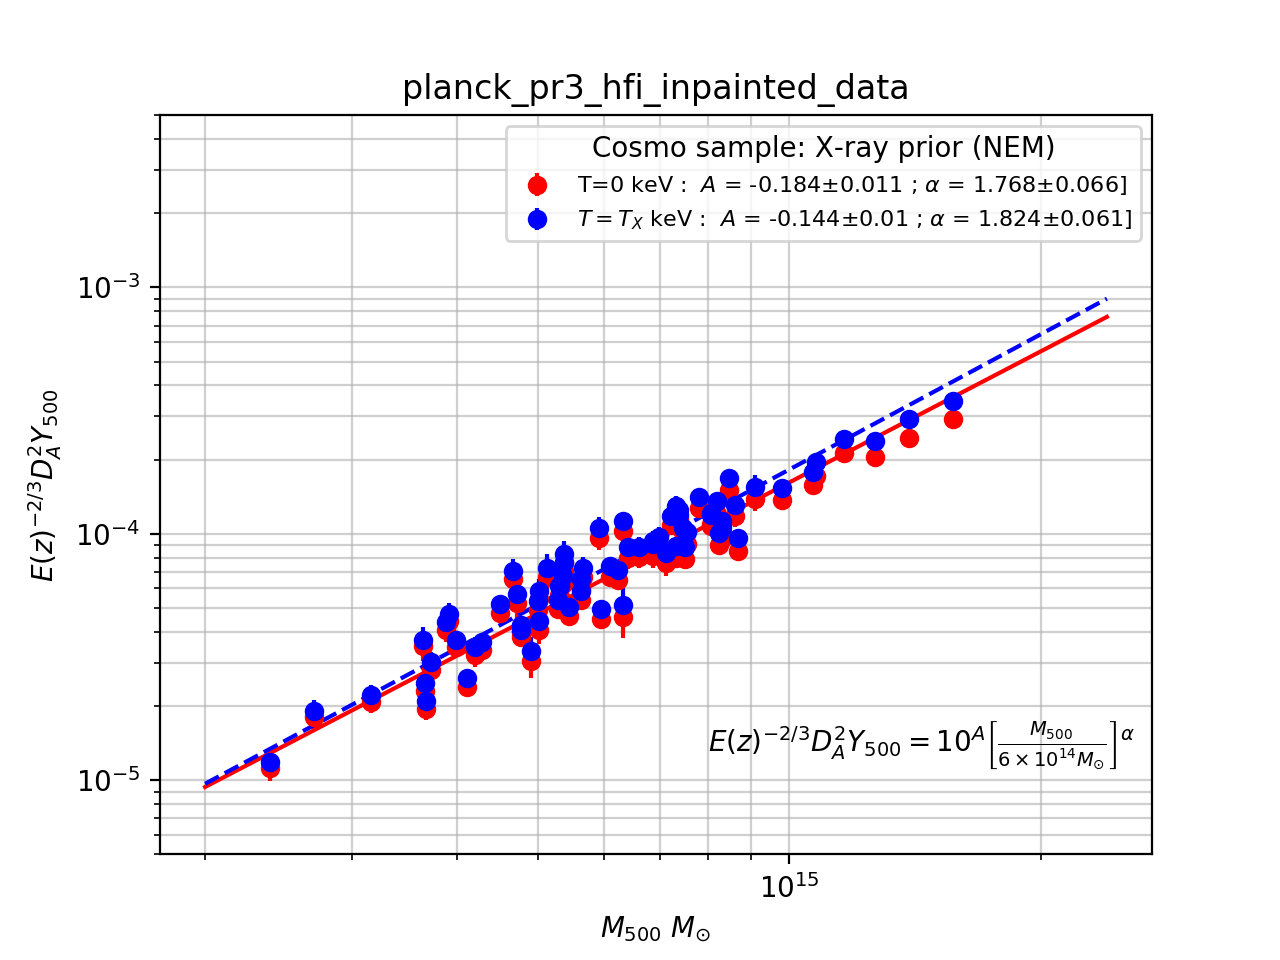

<IPython.core.display.Javascript object>


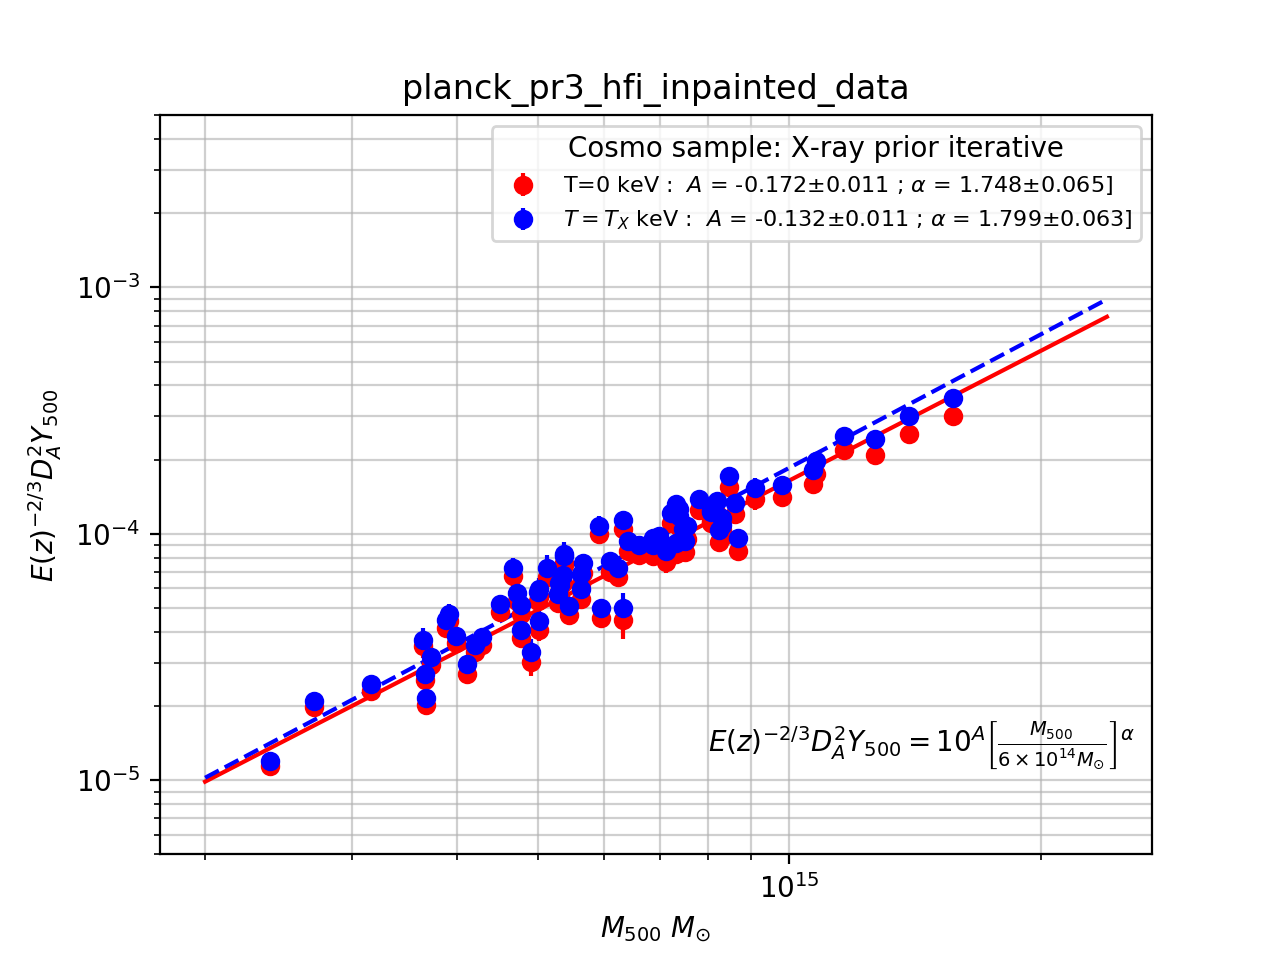

<IPython.core.display.Javascript object>


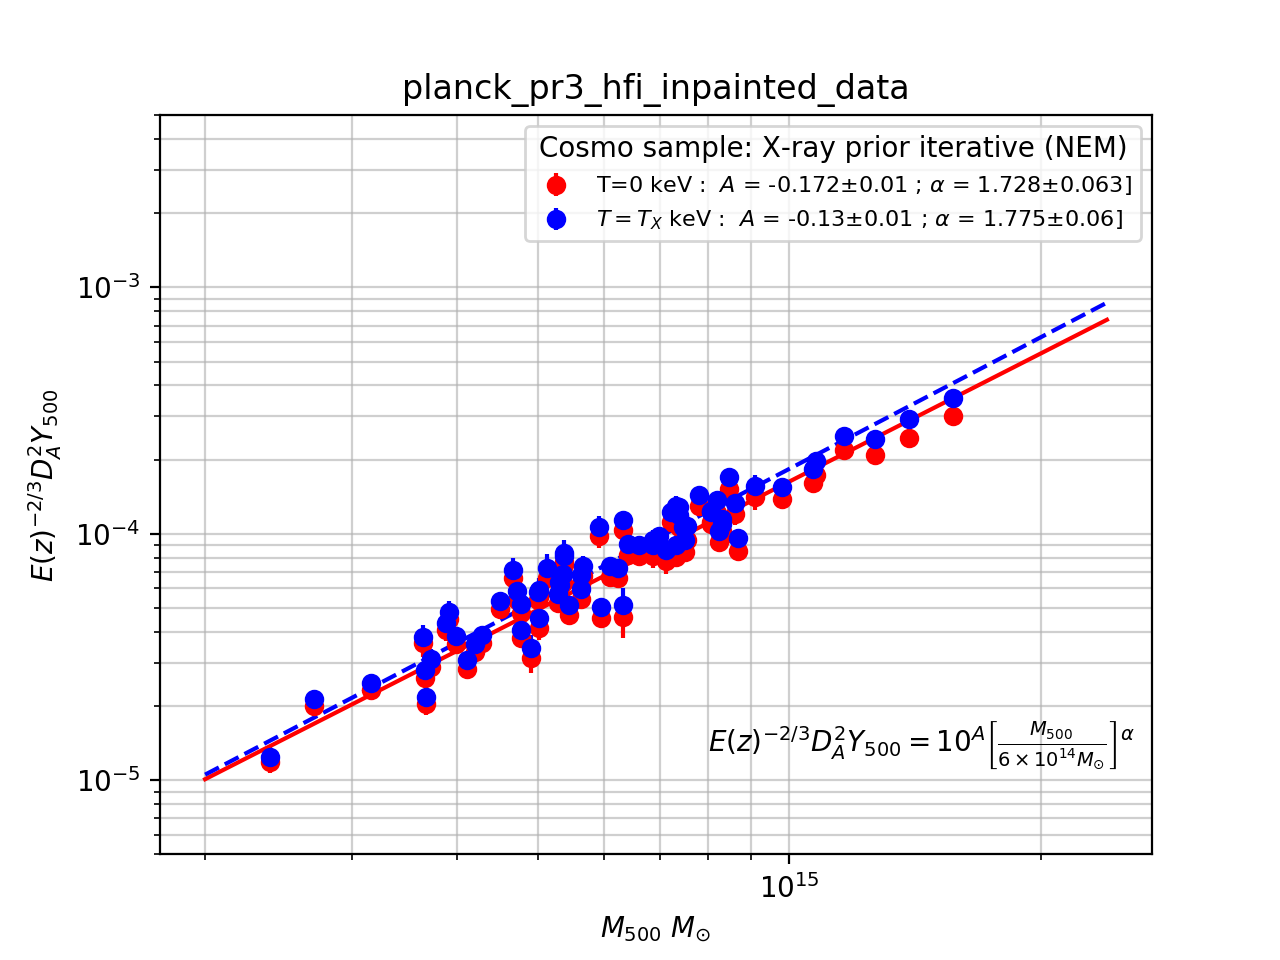

<IPython.core.display.Javascript object>


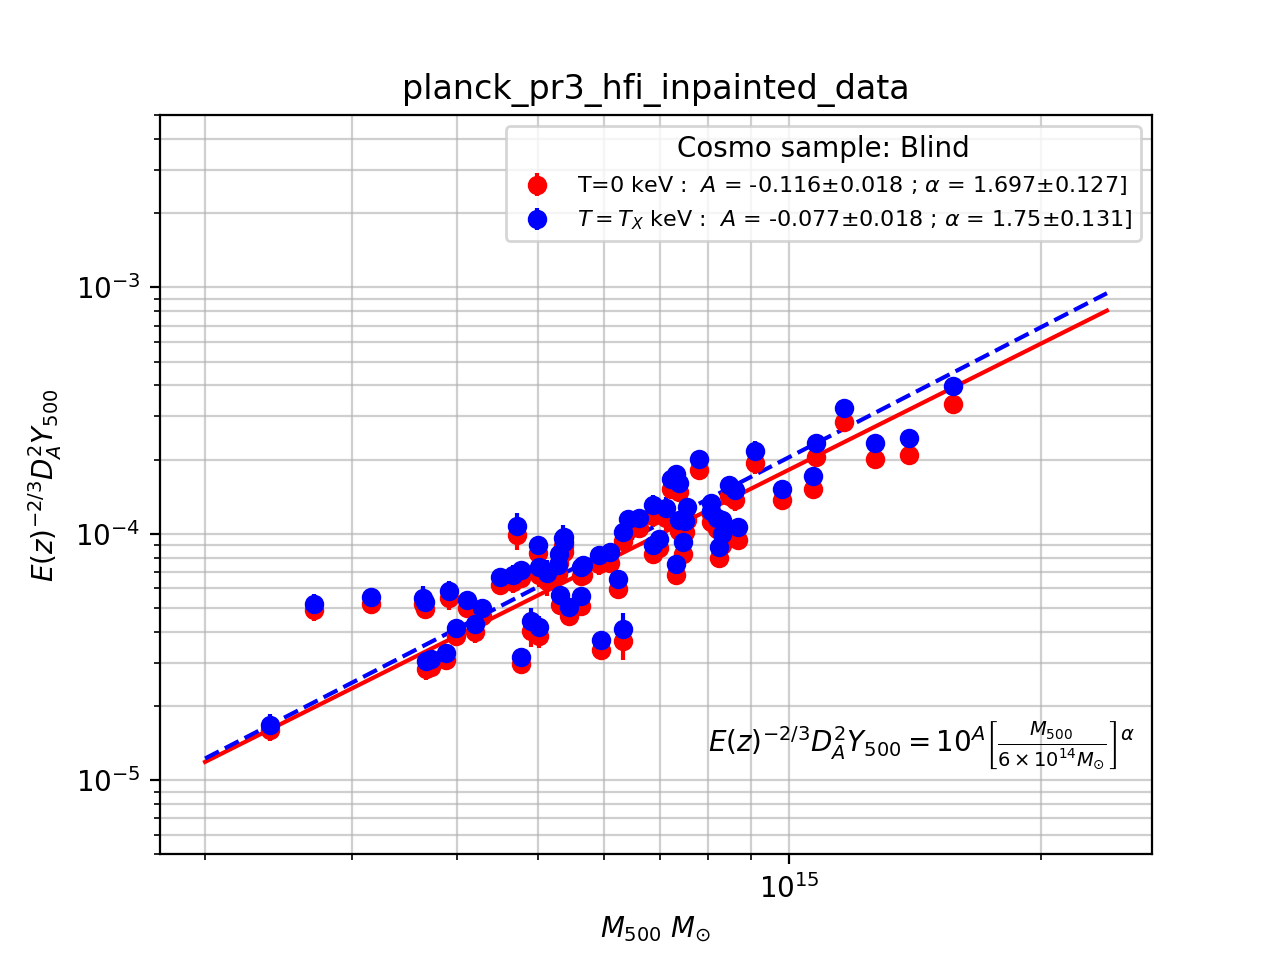

<IPython.core.display.Javascript object>


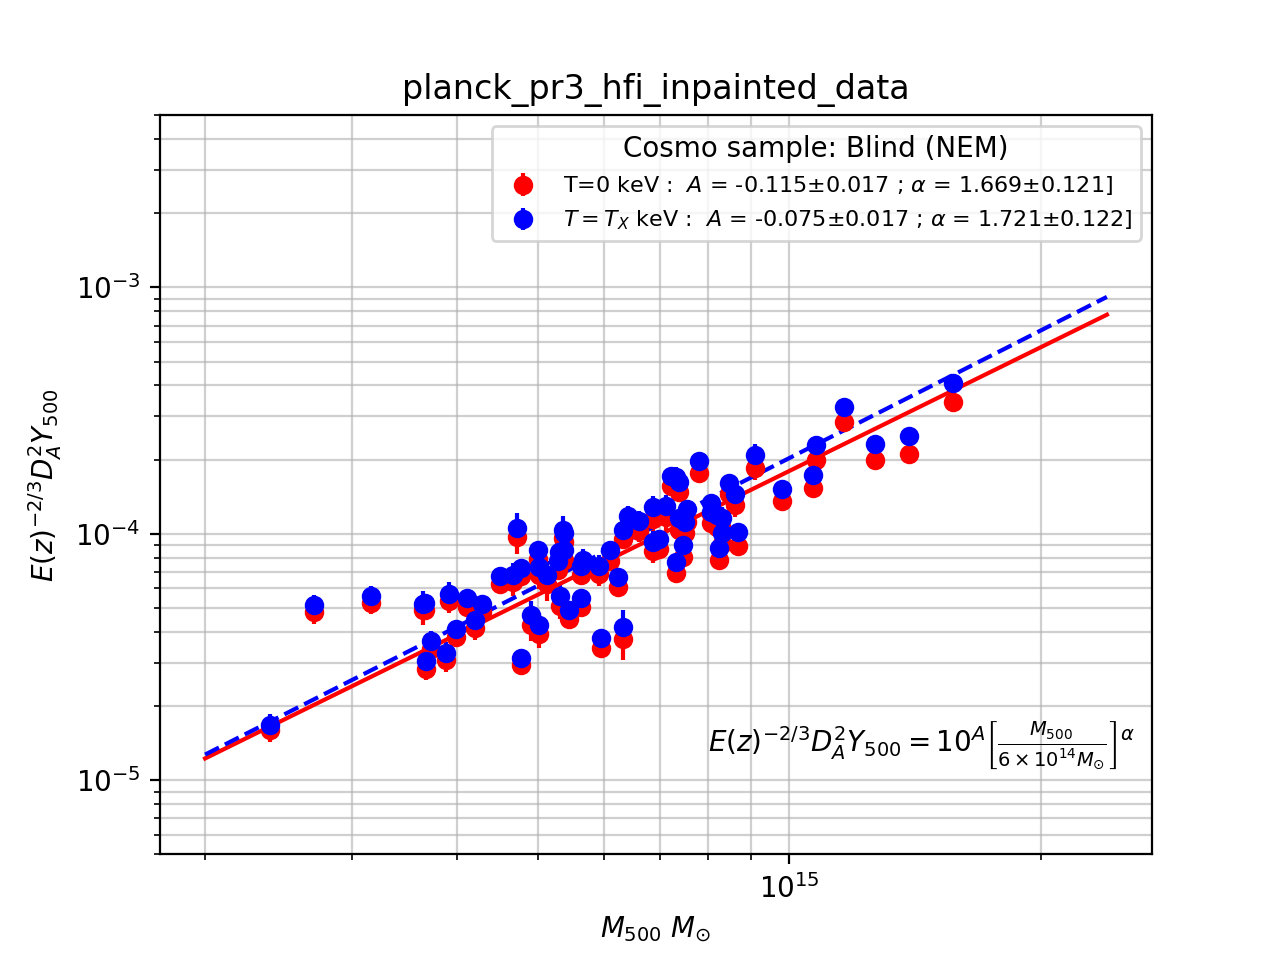

In [176]:
for ia,atype in enumerate(anatype):  
    figure()
    lbl="T=0 keV : "
    lbl=lbl + r" $A$ = " + str(round(fitT0[atype][2],numdec)) + r"$\pm$" + str(round(fitT0[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitT0[atype][0],numdec))  + r"$\pm$" + str(round(fitT0[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err"]*Ezgamma*norm,fmt="o",c="r",label=lbl)
    plot(M500*1e14,(10.**fitT0[atype][2])*((M500/6.)**fitT0[atype][0])*norm,c="r")
    lbl="$T=T_X$ keV : "
    lbl=lbl + r" $A$ = " + str(round(fitTT[atype][2],numdec)) + r"$\pm$" + str(round(fitTT[atype][3],numdec)) 
    lbl=lbl + r" ; $\alpha$ = " +str(round(fitTT[atype][0],numdec))  + r"$\pm$" + str(round(fitTT[atype][1],numdec)) + "]" 
    errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat[atype]["YSZ_500_Tc"]*norm,yerr=fxsz_cat[atype]["YSZ_500_err_Tc"]*Ezgamma*norm,fmt="o",c="b",label=lbl)
    plot(M500*1e14,(10.**fitTT[atype][2])*((M500/6.)**fitTT[atype][0])*norm,"b--")

    ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
    xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
    lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
    text(8e14,1.3e-5,lbl)
    legend(loc=0,title="Cosmo sample: " + labels[atype],fontsize=8)
    ylim(5e-6,5e-3)
    title(figstamp)
    loglog()
    grid(which="both",alpha=0.6)
    if save_results:
        figname=figpath + "Y500_vs_M500_rSZ_correction_" + atype + ".pdf"
        savefig(figname,bbox_inches="tight")

# Malmquist bias and intrinsic scatter

In [529]:
fitcat=fit.return_Y_M_fit(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"],xsz_cat["M500"],xsz_cat["M500_err"],xsz_cat["z"],mbias=xsz_cat["BIAS"])

fitT0={}
for atype in anatype:
    fitT0[atype]=fit.return_Y_M_fit(fxsz_cat[atype]["YSZ_500"],fxsz_cat[atype]["YSZ_500_err"],xsz_cat["M500"],xsz_cat["M500_err"],xsz_cat["z"])
    

fitT0f={}
for atype in anatype:
    fitT0f[atype]=fit.return_Y_M_fit(fxsz_cat[atype]["YSZ_500"],fxsz_cat[atype]["YSZ_500_err"],xsz_cat["M500"],xsz_cat["M500_err"],xsz_cat["z"],mbias=xsz_cat["BIAS"])
    
fitTT={}
for atype in anatype:
    fitTT[atype]=fit.return_Y_M_fit(fxsz_cat[atype]["YSZ_500_Tc"],fxsz_cat[atype]["YSZ_500_err_Tc"],xsz_cat["M500"],xsz_cat["M500_err"],xsz_cat["z"])

In [530]:
print "-------CATALOGUE----------------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitcat[k]
print "--------------------------------"    

print ""
print "--------X-ray prior-------------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitT0["xnm"][k]
print "--------------------------------"    

print ""       
print "--------X-ray prior rSZ---------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitTT["xnm"][k]
print "--------------------------------"    

print ""       
print "--------Blind-------------------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitT0["bnm"][k]
print "--------------------------------"    

-------CATALOGUE----------------
A :  -0.186089443541
A_err :  0.0110193675232
alpha :  1.7863678045
alpha_err :  0.0633764326376
sigma_int :  0.0633089919789
sigma_int_corr :  0.0721181659583
sigma_int_corr_err :  0.00762856960688
sigma_int_err :  0.00762856960688
sigma_raw :  0.0770064793748
sigma_raw_err :  0.00557898581224
sigma_stat :  0.0438402714445
sigma_stat_err :  0.00520288300405
--------------------------------

--------X-ray prior-------------
A :  -0.184735202549
A_err :  0.0103997983726
alpha :  1.77408210004
alpha_err :  0.0624194845213
sigma_int :  0.061899998056
sigma_int_corr :  0.0709731910106
sigma_int_corr_err :  0.00832857738438
sigma_int_err :  0.00832857738438
sigma_raw :  0.0789468473013
sigma_raw_err :  0.00596224547583
sigma_stat :  0.048999948362
sigma_stat_err :  0.00581522399684
--------------------------------

--------X-ray prior rSZ---------
A :  -0.145038540403
A_err :  0.0103910026188
alpha :  1.82389875424
alpha_err :  0.0591792840071
sigma_int :  0

In [178]:
print "-------CATALOGUE----------------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitcat[k]
print "--------------------------------"    

print ""
print "--------X-ray prior-------------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitT0["xnm"][k]
print "--------------------------------"    

print ""       
print "--------X-ray prior rSZ---------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitTT["xnm"][k]
print "--------------------------------"    

print ""       
print "--------Blind-------------------"
for k in sorted(fitcat.keys()):
    if k!="BIAS":
        print k,": ",fitT0["bnm"][k]
print "--------------------------------"    


-------CATALOGUE----------------
A :  -0.186089443541
A_err :  0.0110193675232
alpha :  1.7863678045
alpha_err :  0.0633764326376
sigma_int :  0.0633089919789
sigma_int_corr :  0.0721181659583
sigma_int_corr_err :  0.00762856960688
sigma_int_err :  0.00762856960688
sigma_raw :  0.0770064793748
sigma_raw_err :  0.00557898581224
sigma_stat :  0.0438402714445
sigma_stat_err :  0.00520288300405
--------------------------------

--------X-ray prior-------------
A :  -0.17955628408
A_err :  0.0109948783418
alpha :  1.77558527007
alpha_err :  0.0694012123927
sigma_int :  0.0654255137223
sigma_int_corr :  0.0740576322169
sigma_int_corr_err :  0.0073209421113
sigma_int_err :  0.0073209421113
sigma_raw :  0.0775409021253
sigma_raw_err :  0.00540374944766
sigma_stat :  0.0416184292901
sigma_stat_err :  0.00493919885244
--------------------------------

--------X-ray prior rSZ---------
A :  -0.138753005318
A_err :  0.0107255283327
alpha :  1.82503112815
alpha_err :  0.0658067731568
sigma_int :  0.

# Error on raw scatter

In [64]:
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
xdata=np.log10(xsz_cat["M500"]/6.)
ydata=np.log10(xsz_cat["YSZ_500"]*Ezgamma/xsz_cat["BIAS"])
qY500=xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"] ; yerr=np.log10(1. + 1./qY500)
qM500=xsz_cat["M500"]/xsz_cat["M500_err"] ; xerr=np.log10(1. + 1./qM500)
dvar=yerr**2. + (fitcat["alpha"]**2.)*(xerr**2.)
N=np.size(yerr)
w=(N/dvar)/np.sum(1./dvar)

dmm=ydata - fitcat["alpha"]*xdata - fitcat["A"]
var_raw=np.sum(w*(dmm**2.))/(N-2.)
var_raw_var=(1./np.sum(1./dvar))*(N/(N-2.))
print np.sqrt(var_raw),np.sqrt(var_raw_var)

0.079813531204 0.00541814590332


In [65]:
alpha=np.random.normal(fitcat["alpha"],fitcat["alpha_err"],100000)
A=np.random.normal(fitcat["A"],fitcat["A_err"],100000)
temp=np.zeros_like(A)
for i in range(np.size(A)):
    dvar=yerr**2. + (alpha[i]**2.)*(xerr**2.)
    w=(N/dvar)/np.sum(1./dvar)
    dmm=ydata - alpha[i]*xdata - A[i]
    temp[i]=np.sum(w*(dmm**2.))/(N-2.)

In [190]:
alpha

array([ 1.74996688,  1.77868838,  1.93503053, ...,  1.81580841,
        1.87435875,  1.78861191])

In [50]:
alpha=np.random.normal(1.79,0.063,100000)
x=2.*(np.cos(np.arctan(alpha))**2.)*(0.05**2.)
print mean(x),2.*(np.cos(np.arctan(1.79))**2.)*(0.05**2.),std(x)


0.00119172182214 0.00118931519231 6.42795952978e-05


In [39]:
from contextlib import contextmanager
from scipy.special import erfc

def return_Y_M_fit(YSZ_500,YSZ_500_err,M500,M500_err,redshift,qcut=6.,mbias=[],use_approx_err=False,fidx=0,verbose=False):
	np.random.seed(0)

	Ezgamma=(cosmo_fn.Ez(redshift)**(-2./3.))/1e-4
	xdata=np.log10(M500/6.)

	if use_approx_err:
		qM500=M500/M500_err
		xerr=np.log10(1. + 1./qM500)
	else:
		xerr=return_log_err(M500/6.,M500_err/6.)

	N=np.float64(np.size(YSZ_500))

	if mbias==[]:
		mbias=np.ones_like(YSZ_500,dtype=np.float64)
		ombias=np.copy(mbias)*10.

		iteration=0
		while (np.sum(abs(mbias-ombias)/ombias/N>1.e-3) or (iteration<1)) :
			ombias=np.copy(mbias)
			ydata=np.log10(YSZ_500*Ezgamma/ombias)
			if use_approx_err:
				qY500=YSZ_500/YSZ_500_err
				yerr=np.log10(1. + 1./qY500)
			else:
				yerr=return_log_err(YSZ_500*Ezgamma/ombias,YSZ_500_err*Ezgamma/ombias)
			with suppress_stdout():
				alpha,A,alpha_err,A_err,cov_alphaA=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
			dvar=yerr**2. + (alpha[fidx]**2.)*(xerr**2.)
			w=(N/dvar)/np.sum(1./dvar)
			dmm=ydata - alpha[fidx]*xdata - A[fidx]
			var_raw=np.sum(w*(dmm**2.))/(N-2.)
			var_raw_var=(1./np.sum(1./dvar))*(N/(N-2.))
			var_stat=np.sum(yerr**2.)/N
			var_stat_var=var_stat/N
			var_int=var_raw-var_stat
			var_int_var=var_raw_var+var_stat_var
			# See A.3.3 in Planck 2013 Cosmology with CNC
			var_int_corr=var_int + 2.*(np.cos(np.arctan(alpha[3]))**2.)*(0.05**2.)
			var=np.float64(yerr**2. + var_int)

			q=YSZ_500/YSZ_500_err
			x= -np.log10(q/qcut)
			numerator=np.exp(-x**2./(2.*var))*np.sqrt(var)
			denominator=np.sqrt(np.pi/2.)*erfc(x/np.sqrt(2.*var))
			mbias=10.**(numerator/denominator)
			iteration=iteration+1
			if verbose:
				print alpha[3],alpha_err[3],A[3],A_err[3],np.sqrt(var_raw),np.sqrt(var_int)
	else:
		ydata=np.log10(YSZ_500*Ezgamma/mbias)
		if use_approx_err:
			qY500=YSZ_500/YSZ_500_err
			yerr=np.log10(1. + 1./qY500)
		else:
			yerr=return_log_err(YSZ_500*Ezgamma,YSZ_500_err*Ezgamma)
		with suppress_stdout():
			alpha,A,alpha_err,A_err,cov_alphaA=bces.bcesp(xdata,xerr,ydata,yerr,np.zeros_like(xdata),10000)
		dvar=yerr**2. + (alpha[fidx]**2.)*(xerr**2.)
		w=(N/dvar)/np.sum(1./dvar)
		dmm=ydata - alpha[fidx]*xdata - A[fidx]
		var_raw=np.sum(w*(dmm**2.))/(N-2.)
		var_raw_var=(1./np.sum(1./dvar))*(N/(N-2.))
		var_stat=np.sum(yerr**2.)/N
		var_stat_var=var_stat/N
		var_int=var_raw-var_stat
		var_int_var=var_raw_var+var_stat_var
		# See A.3.3 in Planck 2013 Cosmology with CNC
		var_int_corr=var_int + 2.*(np.cos(np.arctan(alpha[3]))**2.)*(0.05**2.)
		if verbose:
			print alpha[3],alpha_err[3],A[3],A_err[3],np.sqrt(var_raw),np.sqrt(var_int)

	result={}
	result["alpha"]=alpha[3]
    result["covalphaA"]=alpha[3]
	result["alpha_err"]=alpha_err[3]
	result["A"]=A[3]
	result["A_err"]=A_err[3]
	result["sigma_raw"]=np.sqrt(var_raw)
	result["sigma_raw_err"]=np.sqrt(var_raw_var)
	result["sigma_int"]=np.sqrt(var_int)
	result["sigma_int_err"]=np.sqrt(var_int_var)
	result["sigma_int_corr"]=np.sqrt(var_int_corr)
	result["sigma_int_corr_err"]=np.sqrt(var_int_var)
	result["sigma_stat"]=np.sqrt(var_stat)
	result["sigma_stat_err"]=np.sqrt(var_stat_var)
	result["BIAS"]=mbias
	return result

def return_log_err(gauss_mean,gauss_err,num_samples=100000,ignore_negatives=True):
    logerr=np.zeros_like(gauss_mean)
    for idx, mu in enumerate(gauss_mean):
        x=np.random.normal(mu,gauss_err[idx],num_samples)
        if ignore_negatives:
            while np.any(x<0):
                neg_idx=np.where(x<0)[0]
                x[neg_idx]=np.random.normal(mu,gauss_err[idx],np.size(neg_idx))
        logerr[idx]=np.std(np.log10(x))
    return logerr


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout



# Error in estimation of log10(Y500) error

<IPython.core.display.Javascript object>


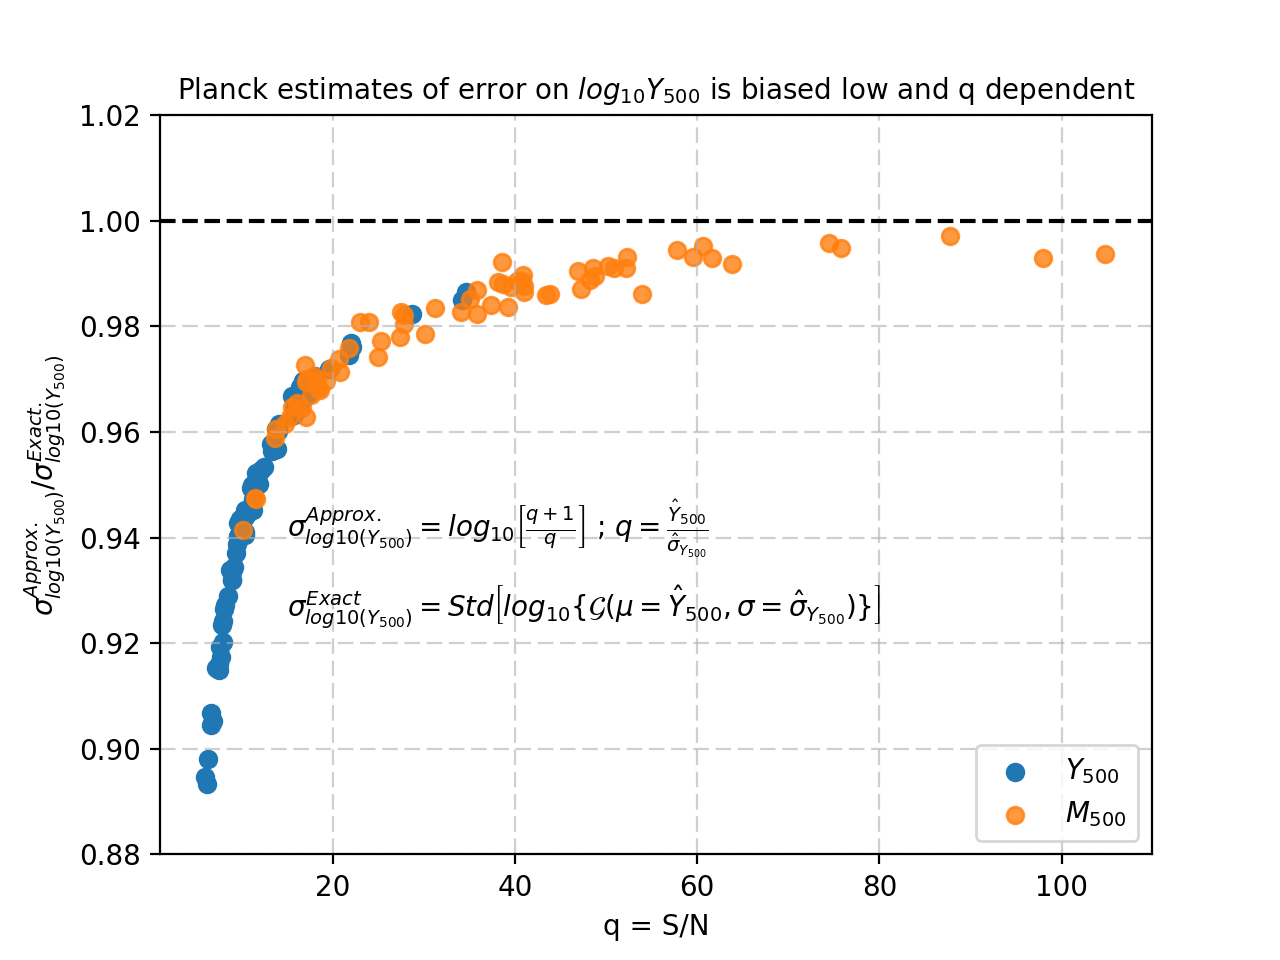

In [9]:
Ezgamma=(cosmo_fn.Ez(xsz_cat["z"])**(-2./3.))/1e-4
np.random.seed(0)
qM500=xsz_cat["M500"]/xsz_cat["M500_err"]
xerr=fit.return_log_err(xsz_cat["M500"]/6.,xsz_cat["M500_err"]/6.)
qY=xsz_cat["YSZ_500"]/xsz_cat["YSZ_500_err"]
yerr=fit.return_log_err(xsz_cat["YSZ_500"]*Ezgamma,xsz_cat["YSZ_500_err"]*Ezgamma)

figure()
scatter(qY,log10(1.+1./qY)/yerr,label="$Y_{500}$")
scatter(qM500,log10(1.+1./qM500)/xerr,label="$M_{500}$",alpha=0.8)
ylabel("$\sigma^{Approx.}_{log10(Y_{500})}/\sigma^{Exact.}_{log10(Y_{500})}$")
xlabel("q = S/N")
title("Planck estimates of error on $log_{10} Y_{500}$ is biased low and q dependent",fontsize=10)
text(15,0.94, r"$\sigma^{Approx.}_{log10(Y_{500})} = log_{10}\left[\frac{q+1}{q}\right]$" + " ; " + r"$q=\frac{\hat{Y}_{500}}{\hat{\sigma}_{Y_{500}}}$")
text(15,0.925, r"$\sigma^{Exact}_{log10(Y_{500})} = Std\left[ log_{10}\lbrace\mathcal{G}(\mu=\hat{Y}_{500},\sigma=\hat{\sigma}_{Y_{500}})\rbrace \right]$")
grid(alpha=0.6,ls="--")
ylim(0.88,1.02)
legend(loc=0)
axhline(1,c="k",ls="--")
figname=figpath + 'log10yerr_faulty_approximation.pdf'
savefig(figname,bbox_inches="tight")